In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from os import listdir
import glob

import midi_manipulation

In [2]:
# if not os.path.exists('Pop_Music_Midi_Manipulated'):
#     os.mkdir('Pop_Music_Midi_Manipulated')
# files = [f for f in listdir('Pop_Music_Midi')]
# for file in files:
# #     midi_manipulation.transpose('Pop_Music_Midi/' + file)
    
#     fileArr = file.split('.')
#     with open(('Pop_Music_Midi_Manipulated/' + fileArr[0] + '.txt'), 'w+') as f:
#         data = midi_manipulation.midiToNoteStateMatrix(('Pop_Music_Midi/' + file))
#         counter = 0
#         dataStr = "["
#         for item in data: 
#             while counter < 64:
#                 dataStr = dataStr + "[" + ",".join([str(x) for x in item]) + "],"
#                 counter += 1
#         dataStr = dataStr + "]"
#         f.write(dataStr)

        
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = []
    for f in files:
        try:
            song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
            if np.array(song).shape[0] > 50:
                songs.append(song)
        except Exception as e:
            raise e           
    return songs

In [3]:
songs = get_songs('Pop_Music_Midi')
print ("{} songs processed".format(len(songs)))

122 songs processed


In [4]:
lowest_note = midi_manipulation.lowerBound #the index of the lowest note on the piano roll
highest_note = midi_manipulation.upperBound #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 15 #This is the number of timesteps that we will create at a time
n_visible      = 2*note_range*num_timesteps #This is the size of the visible layer. 
n_hidden       = 50 #This is the size of the hidden layer

X_dim = n_visible #mnist.train.images.shape[1]
z_dim = n_hidden #100


In [5]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [16]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

# D_W1 = tf.Variable(xavier_init([784, 128]))
D_W1 = tf.Variable(xavier_init([X_dim, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

In [27]:
Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [28]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [29]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [30]:
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [72]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
#         plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        plt.imshow(sample.reshape(78, 30), cmap='Greys_r')


    return fig

In [32]:
print (np.shape(Z))

(?, 100)


In [33]:
G_sample = generator(Z)

In [34]:
print(note_range)

78


In [35]:
D_real, D_logit_real = discriminator(X)

In [36]:
D_fake, D_logit_fake = discriminator(G_sample)

In [37]:
# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))


In [38]:
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [39]:
mb_size = 128
Z_dim = 100

In [65]:
if not os.path.exists('out/'):
    os.makedirs('out/')

In [64]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [63]:
# for song in songs:
#         # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
#         # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
#         song = np.array(song)
#         song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
#         song = np.reshape(song, [int(song.shape[0]/num_timesteps), song.shape[1]*num_timesteps])
#         # Train the RBM on batch_size examples at a time

In [66]:
# i = 0

In [79]:
# for it in range(1000000):
#     if it % 1000 == 0:
#         samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})
        
# #        fig = plot(samples)
# #        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
# #        i += 1
# #        plt.close(fig)
        
# #         S = np.reshape(samples, (num_timesteps, 2*note_range))
# #         thresh_S = S>=0.5
# #         midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_{}".format(i))


#     _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
#     _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

#     if it % 1000 == 0:
#         print('Iter: {}'.format(it))
#         print('D loss: {:.4}'. format(D_loss_curr))
#         print('G_loss: {:.4}'.format(G_loss_curr))
#         print()

ValueError: Cannot feed value of shape (2340,) for Tensor 'Placeholder_2:0', which has shape '(?, 2340)'

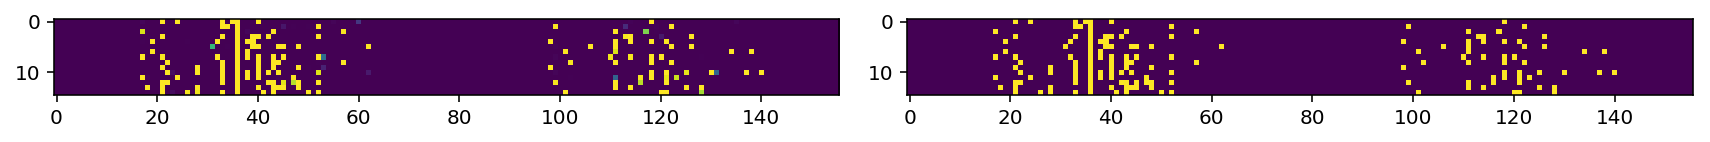

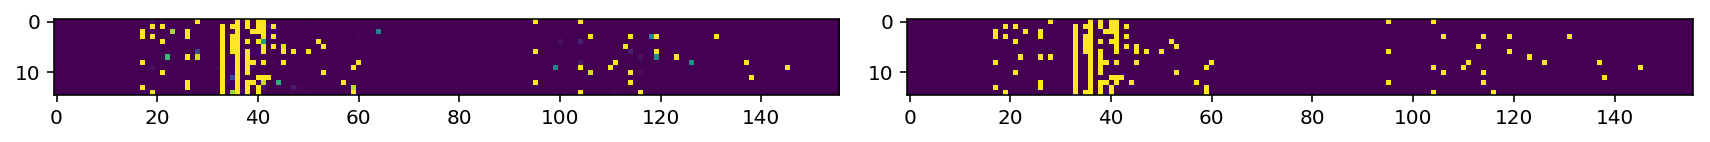

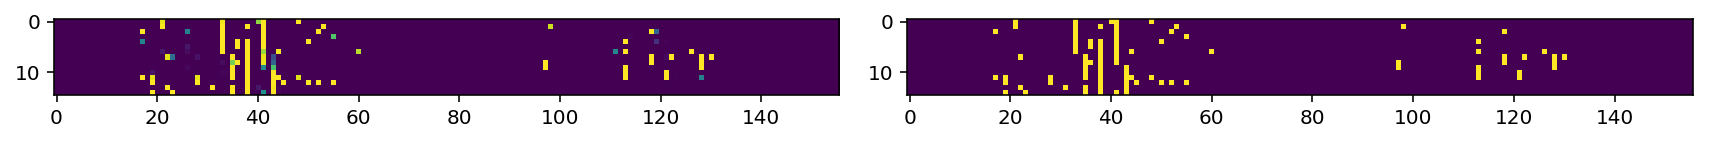

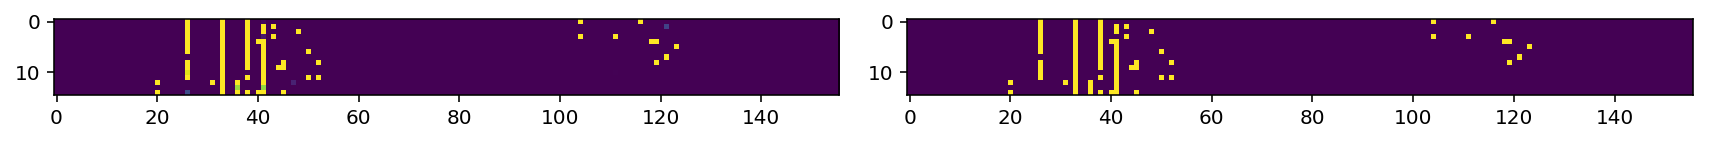

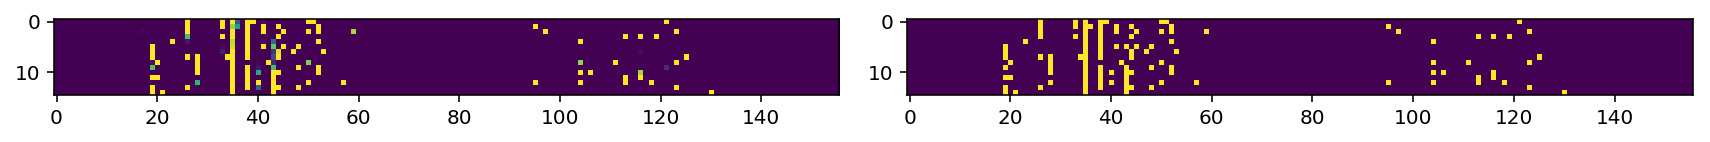

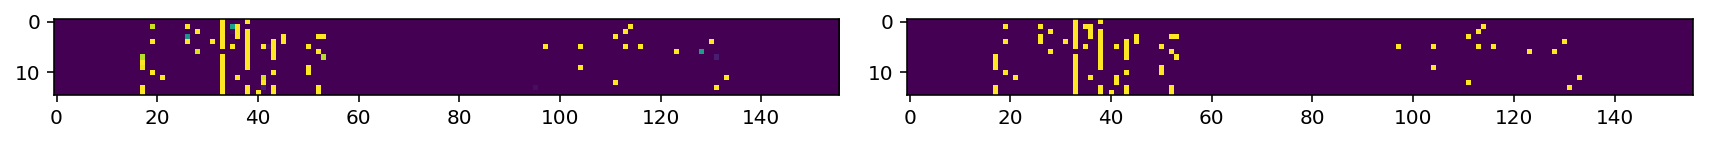

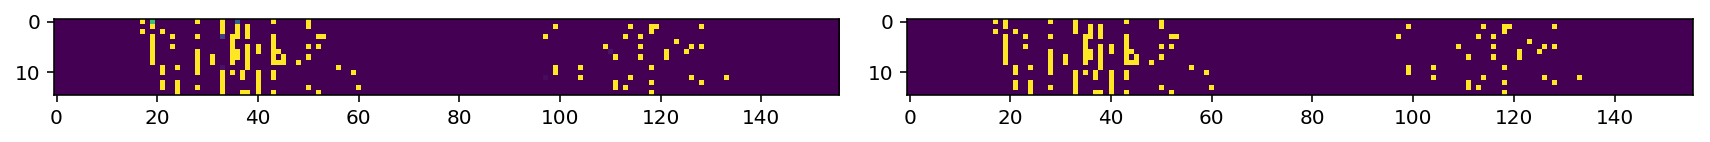

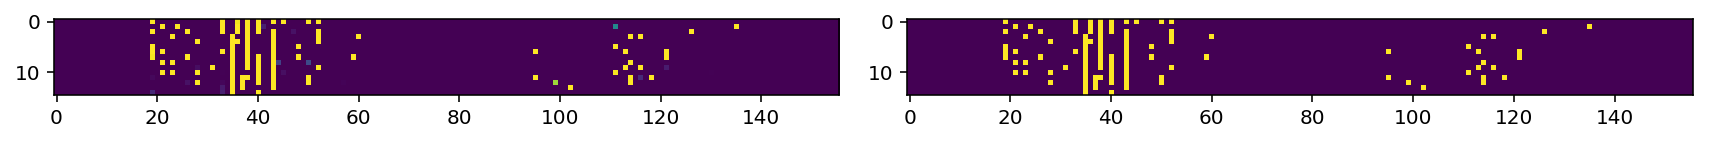

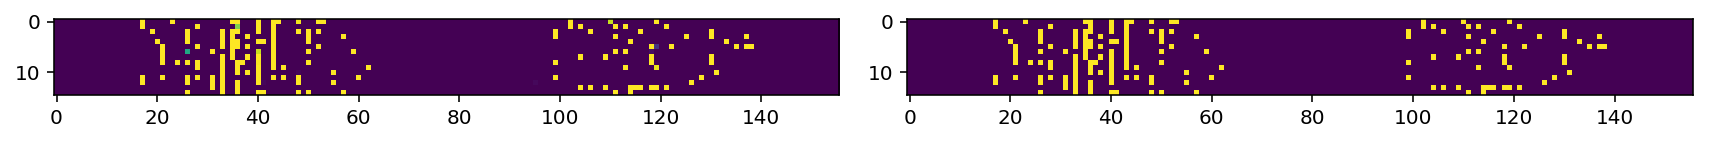

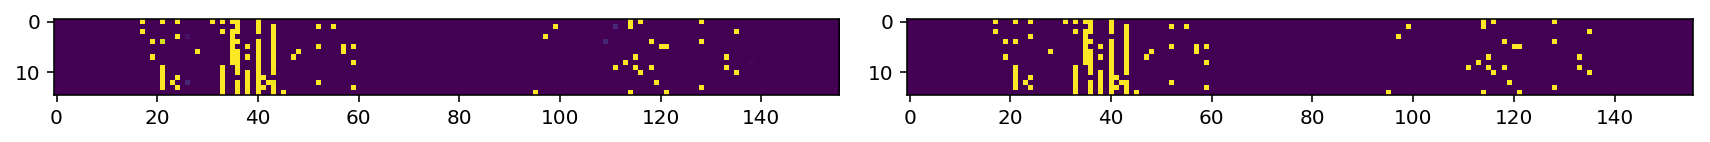

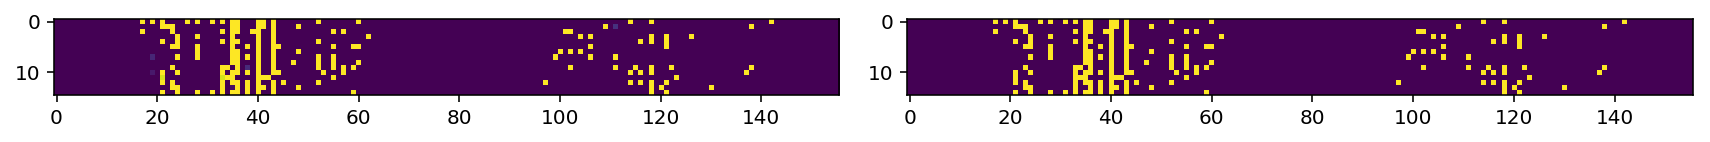

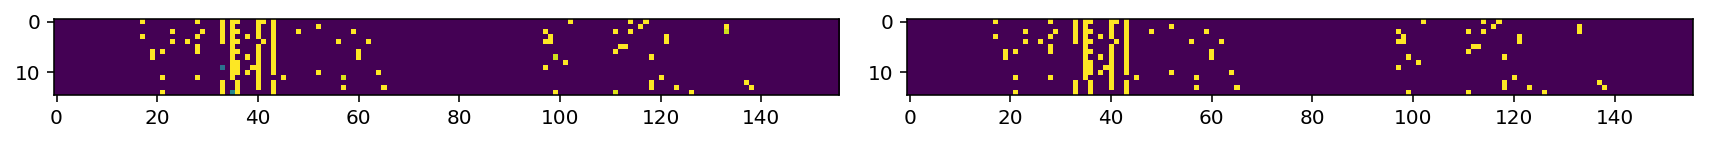

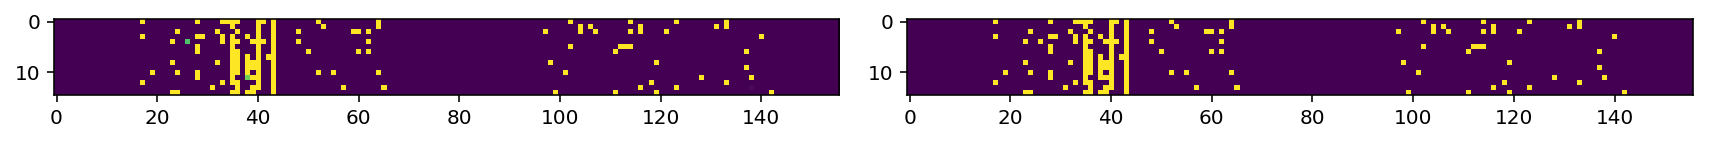

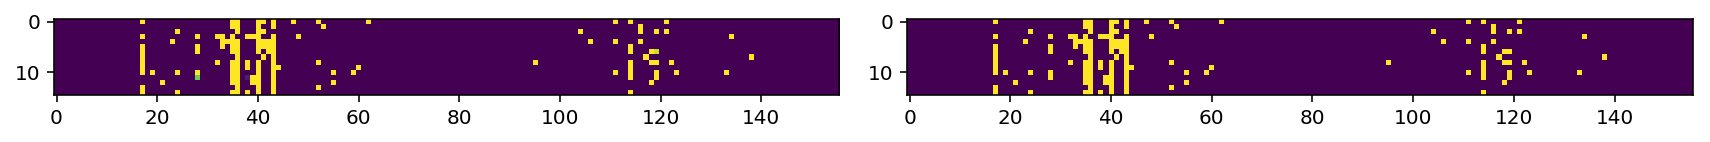

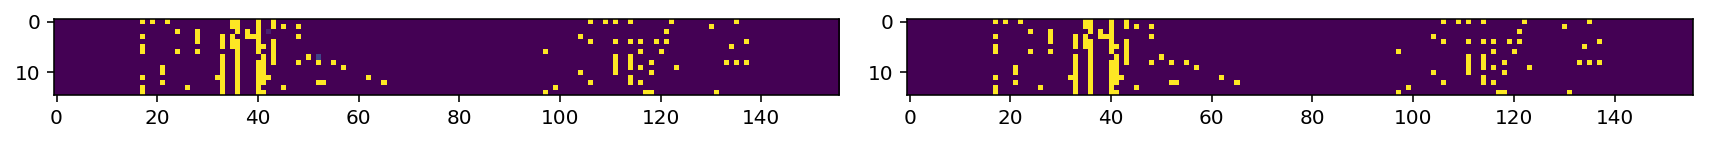

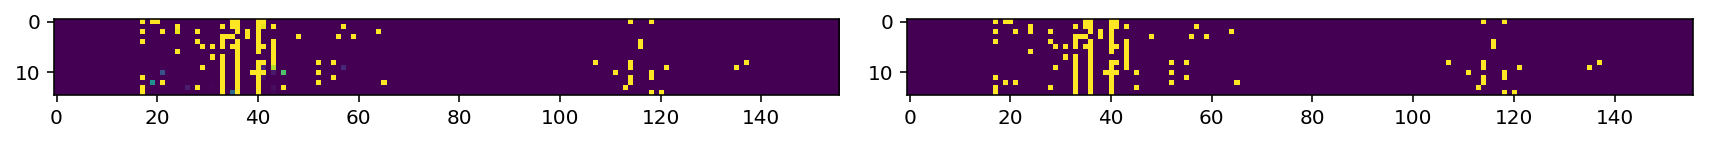

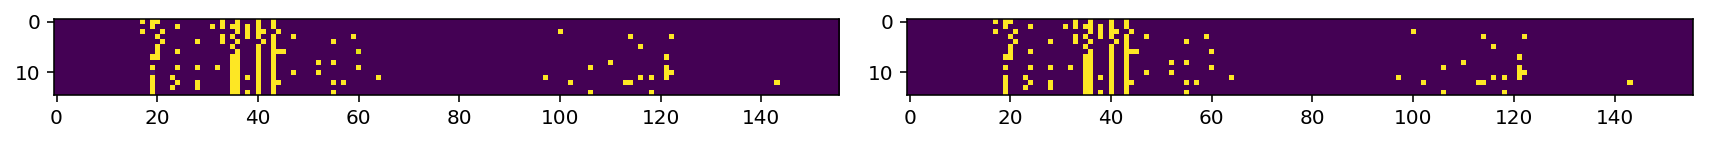

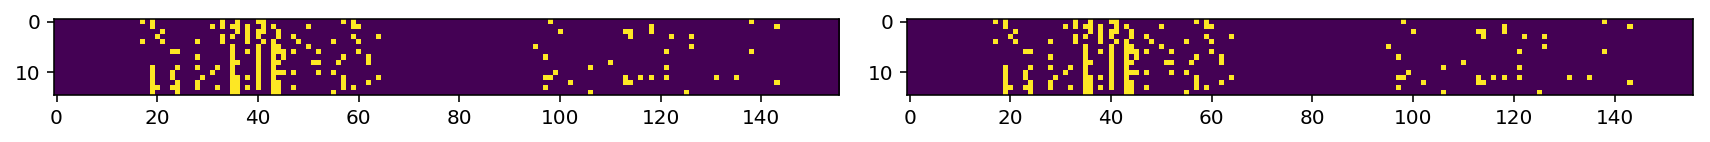

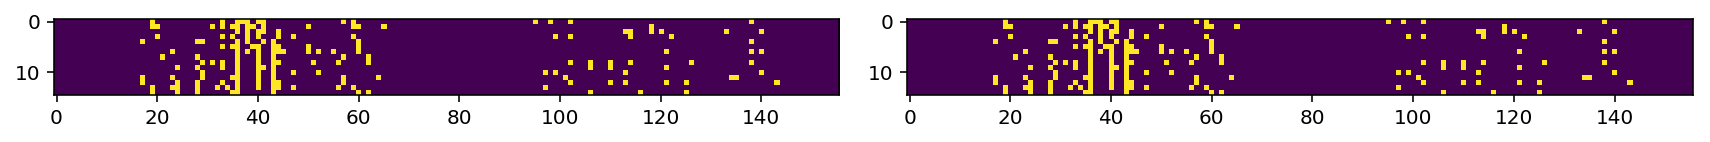

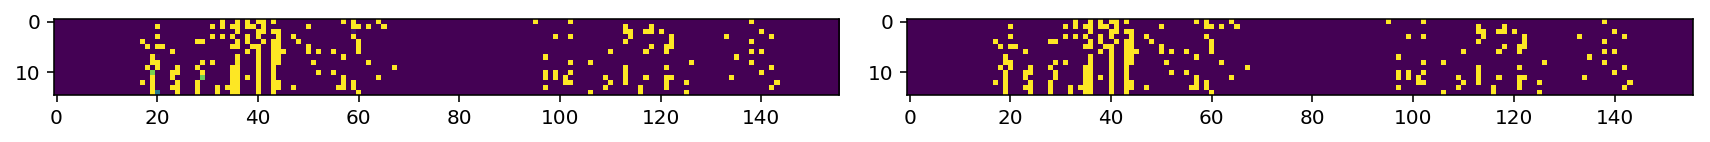

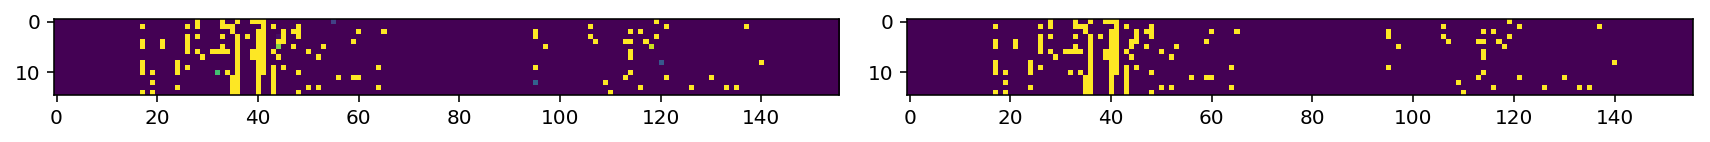

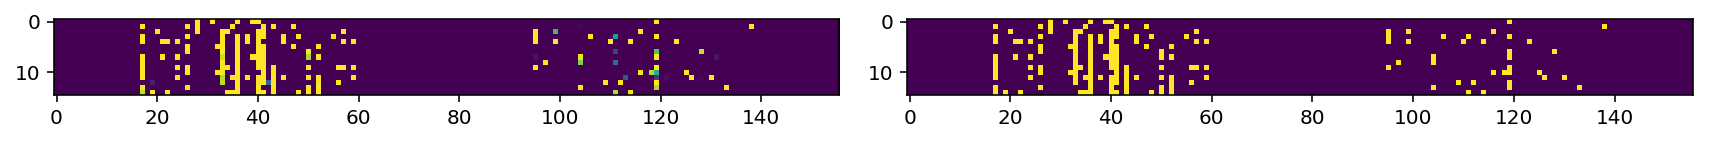

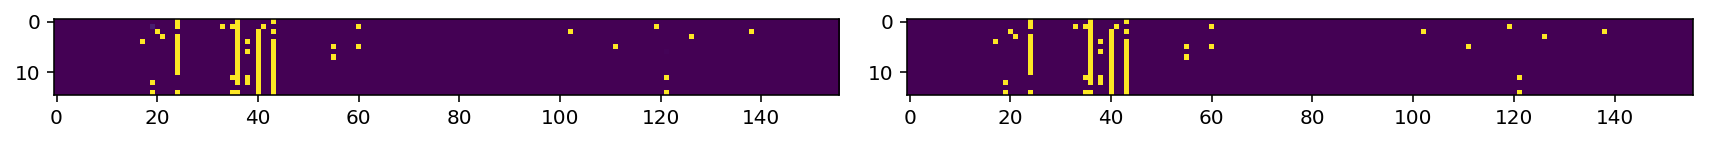

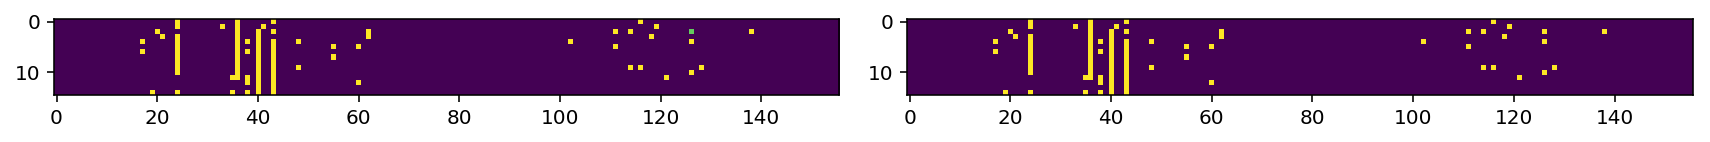

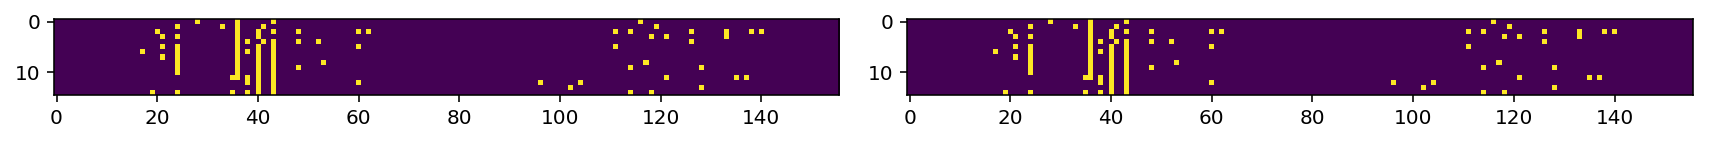

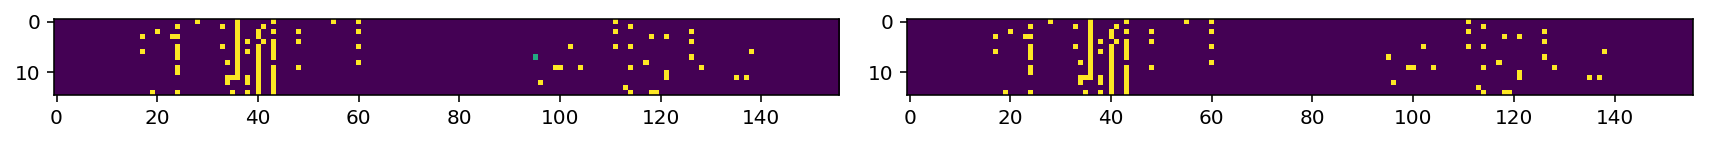

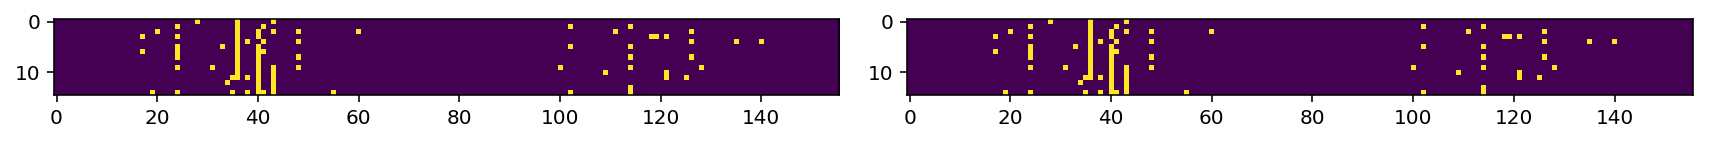

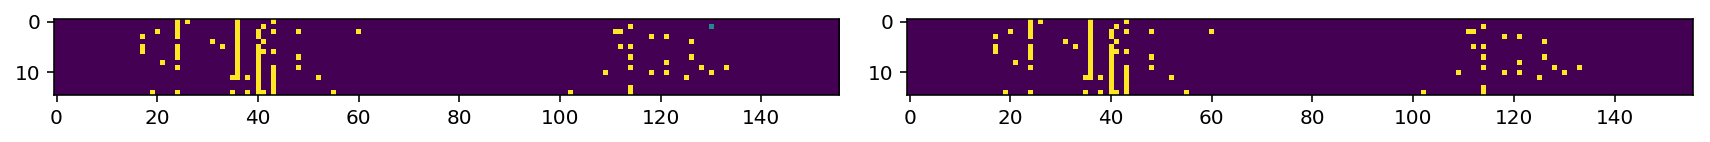

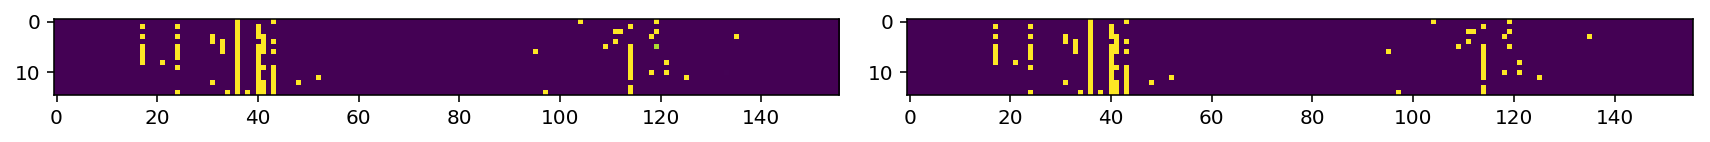

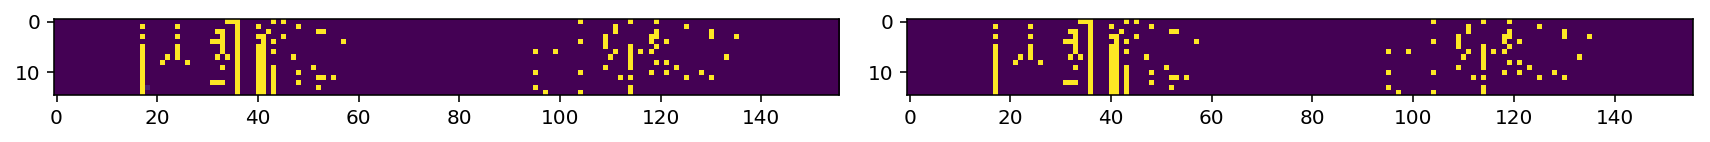

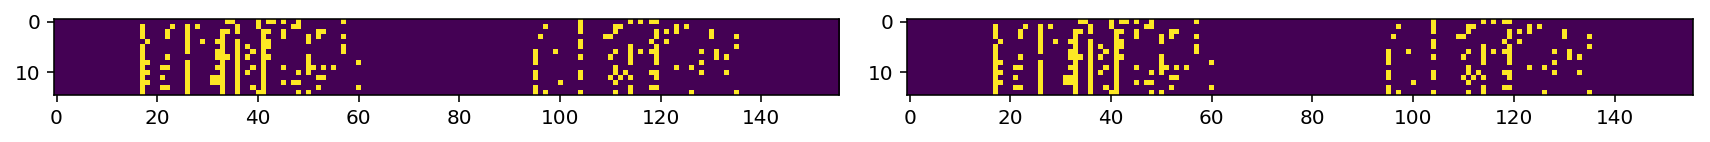

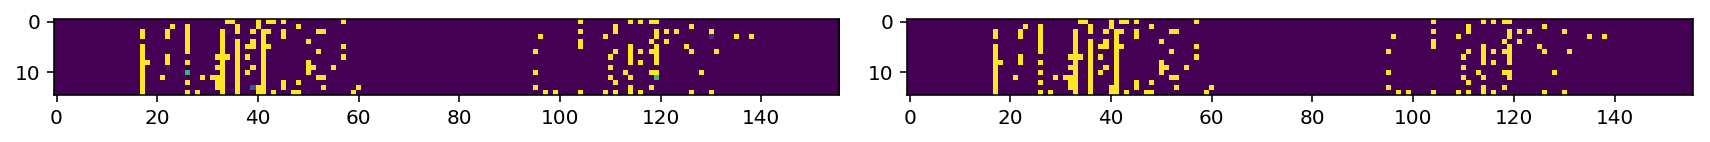

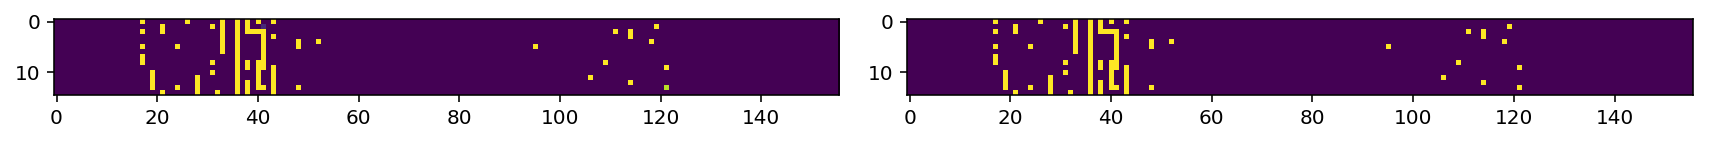

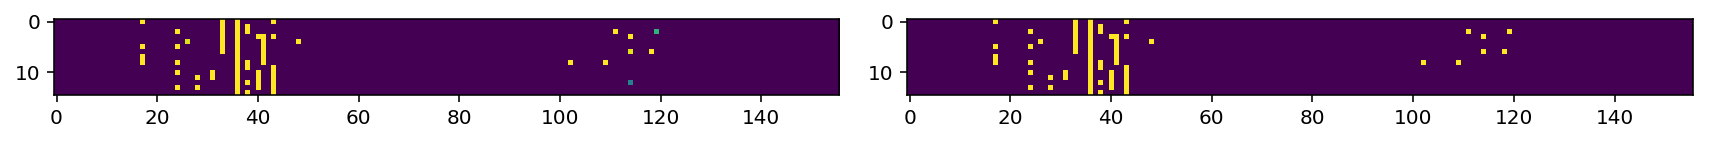

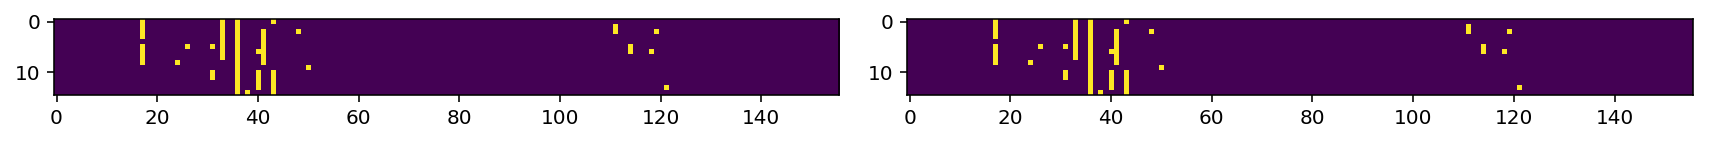

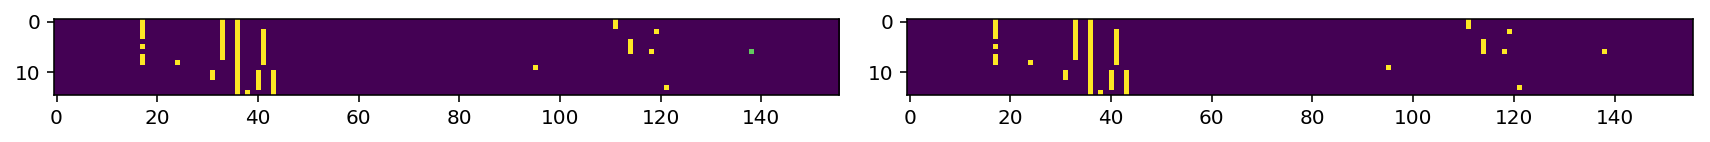

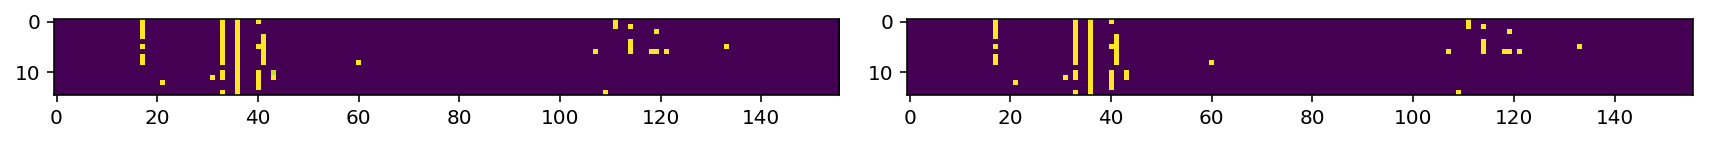

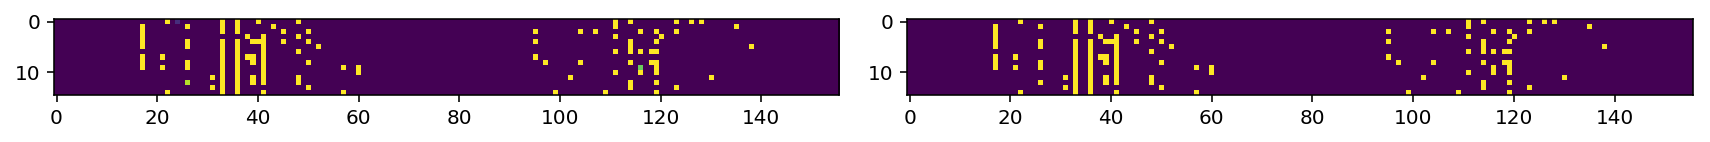

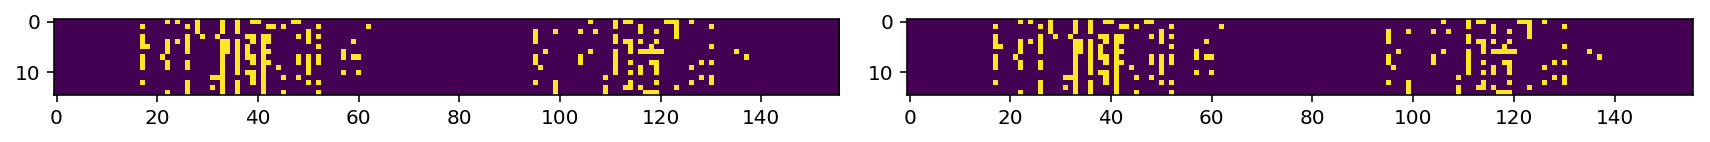

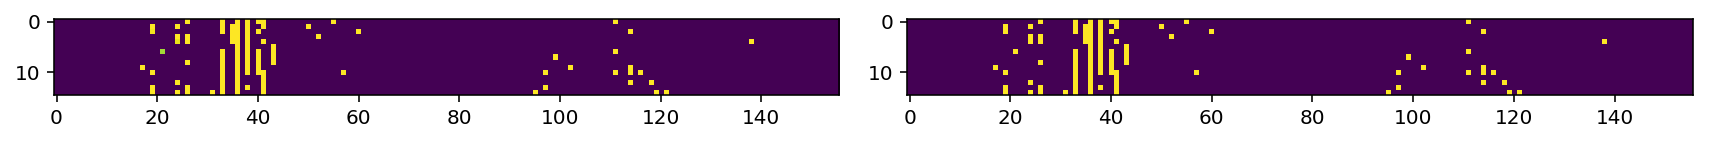

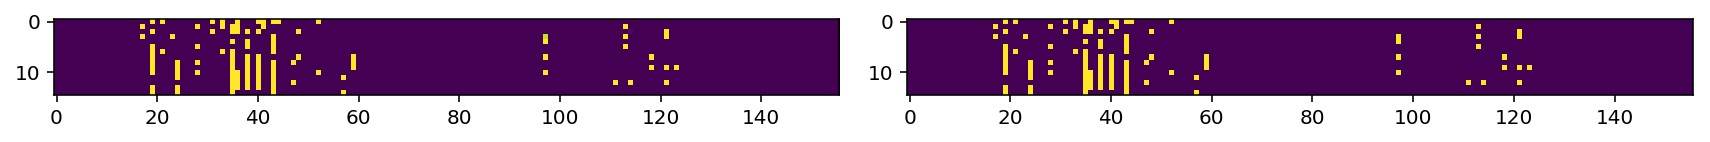

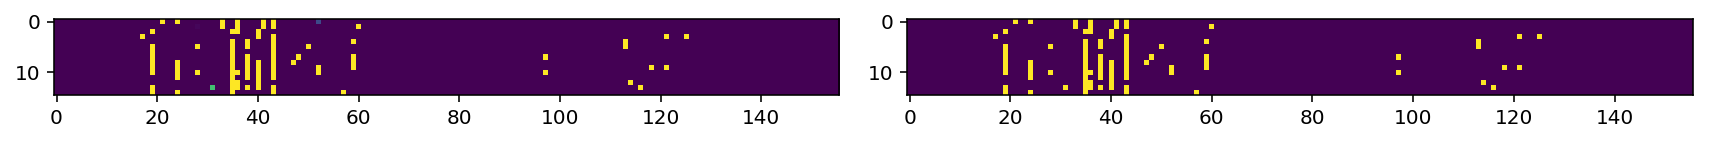

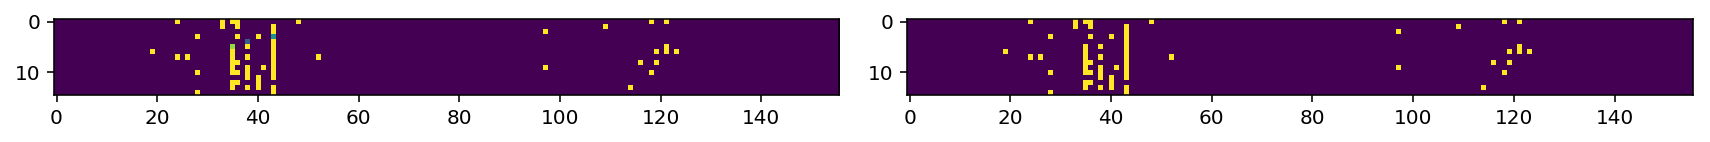

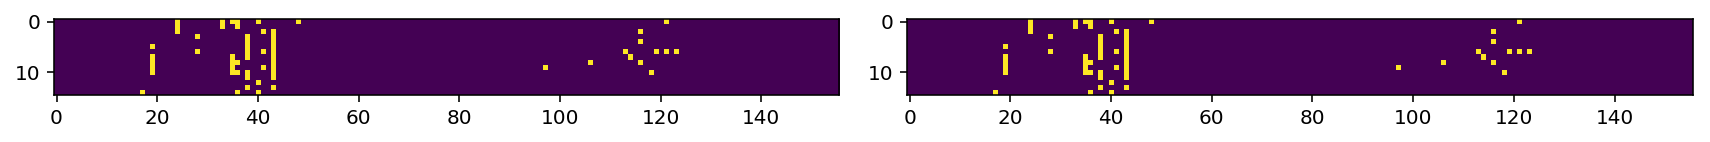

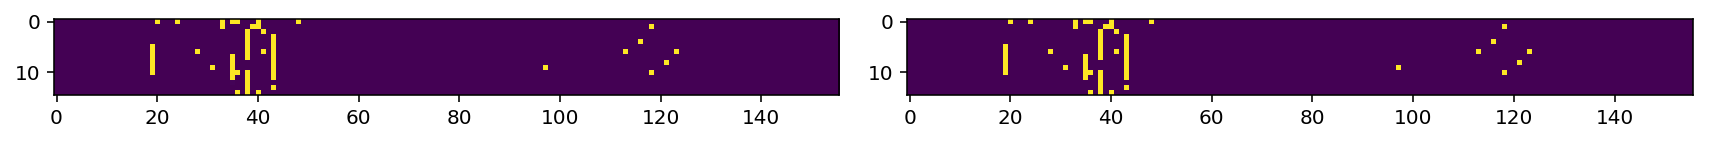

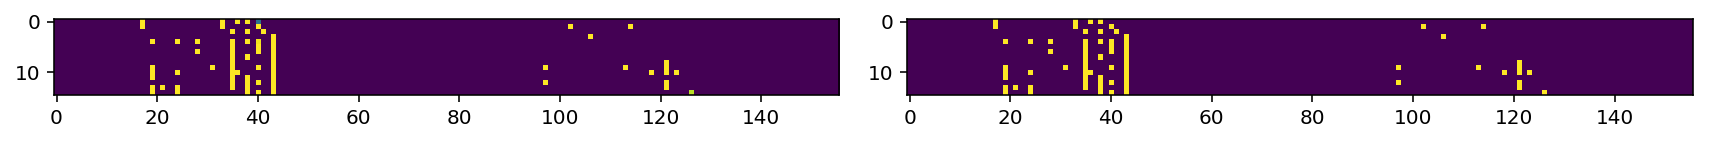

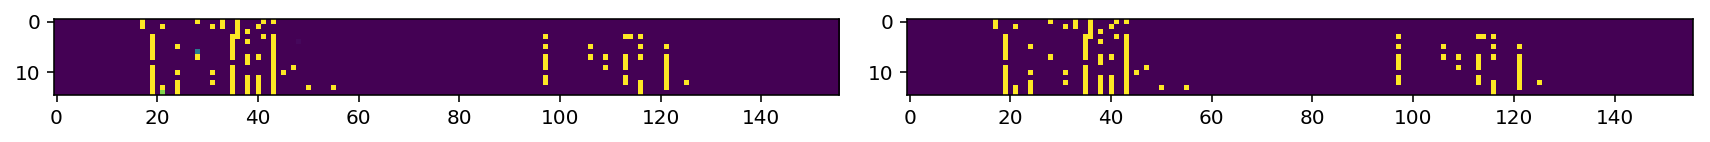

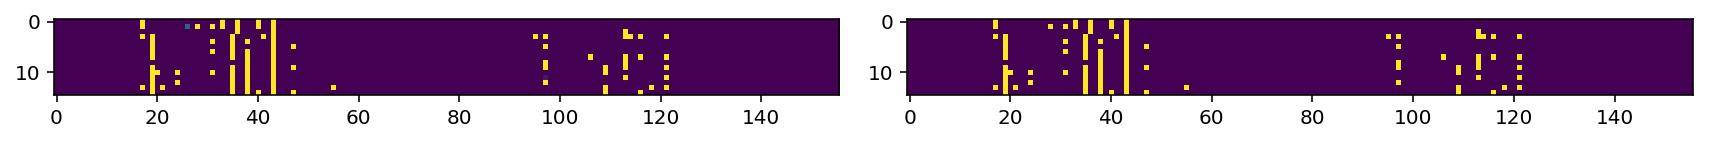

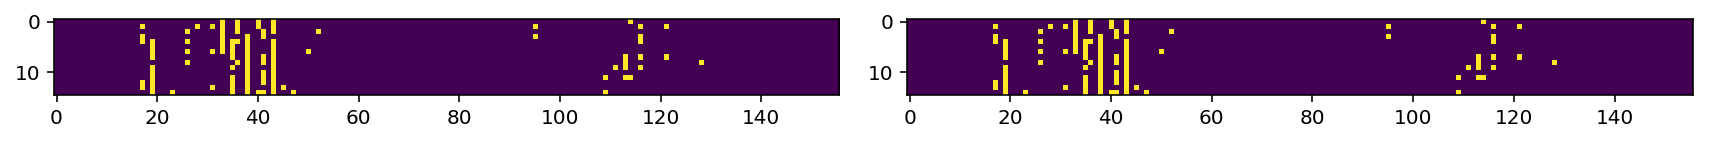

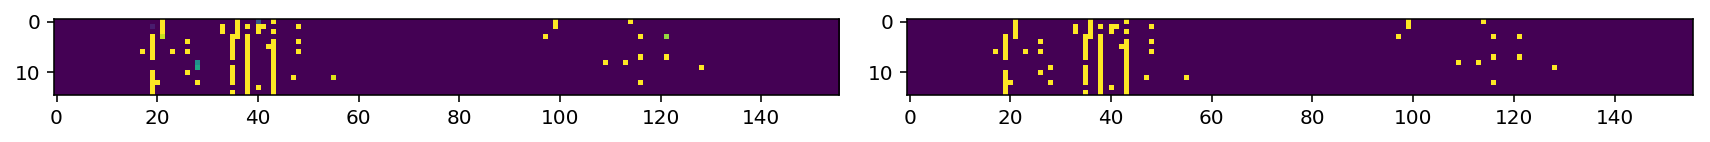

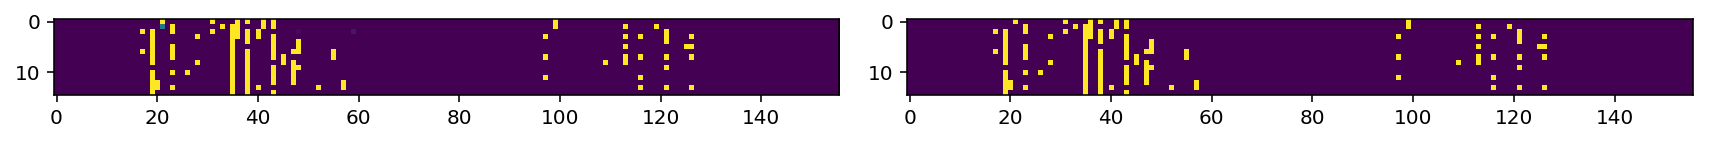

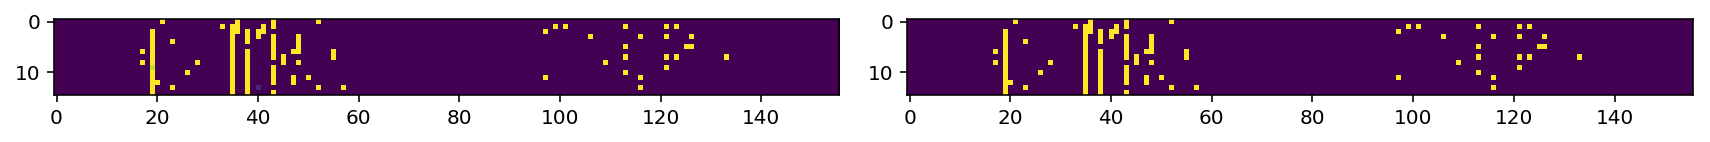

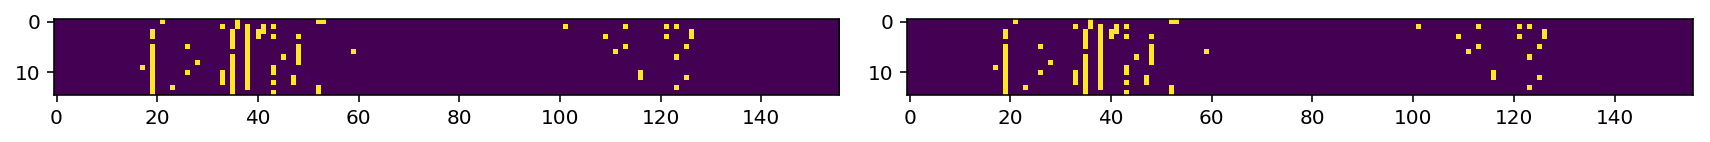

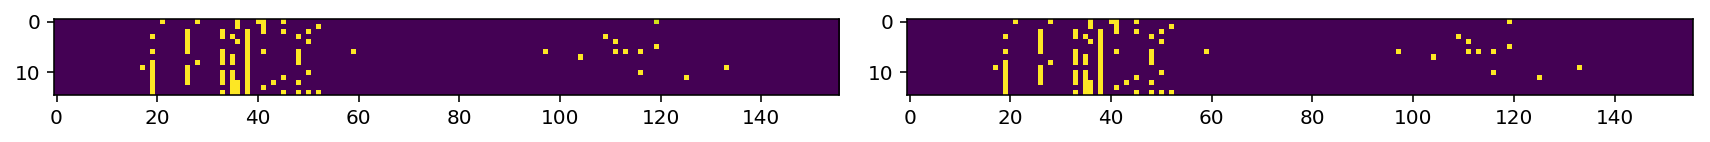

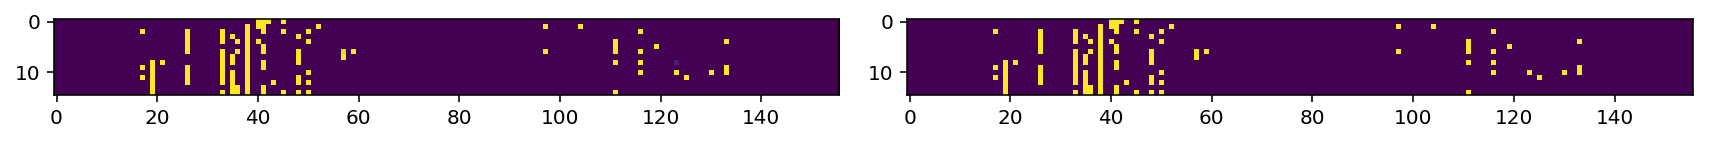

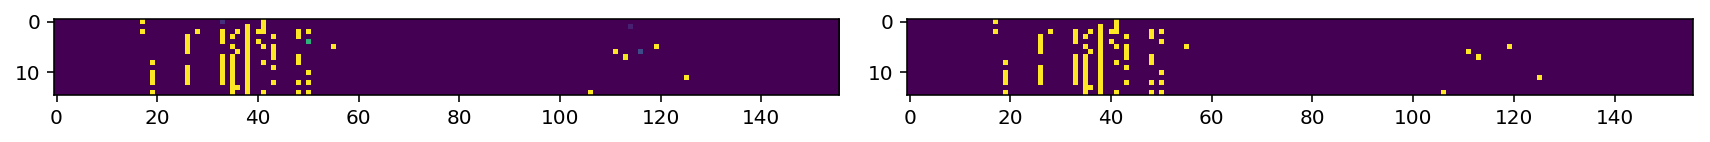

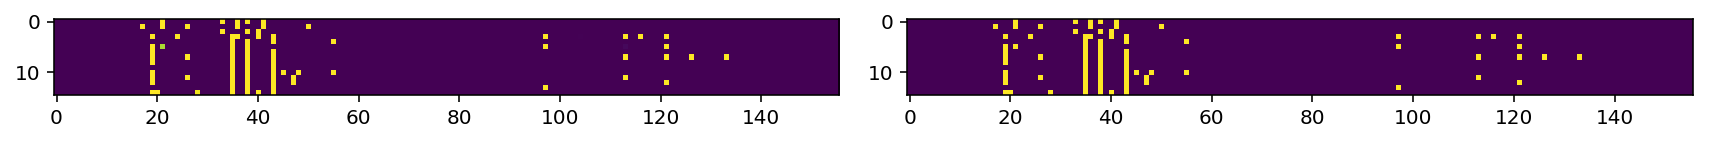

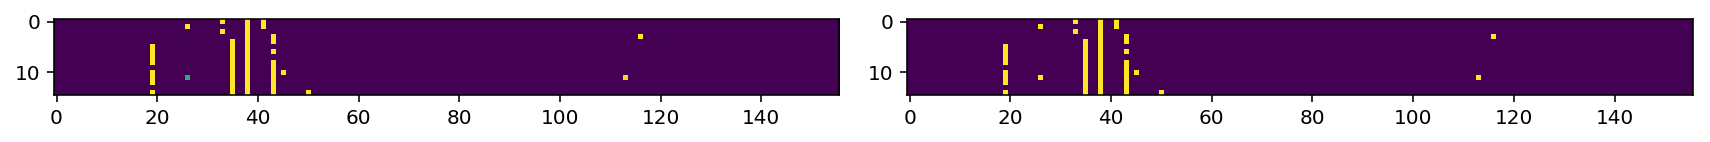

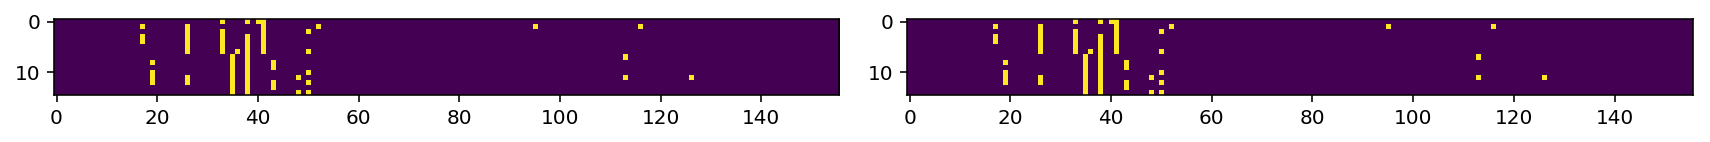

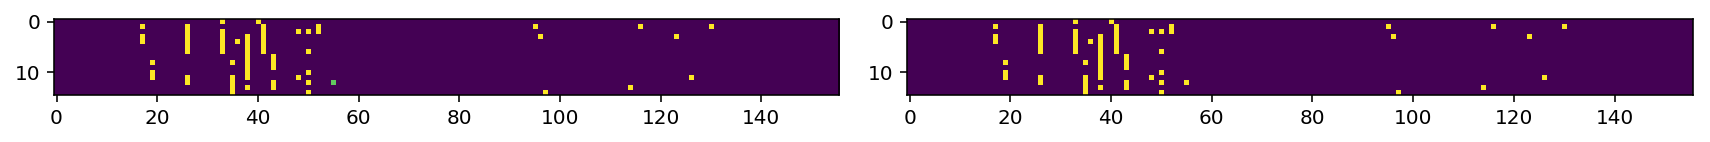

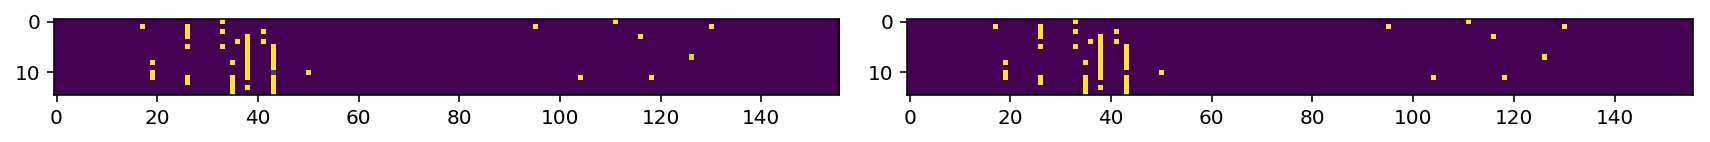

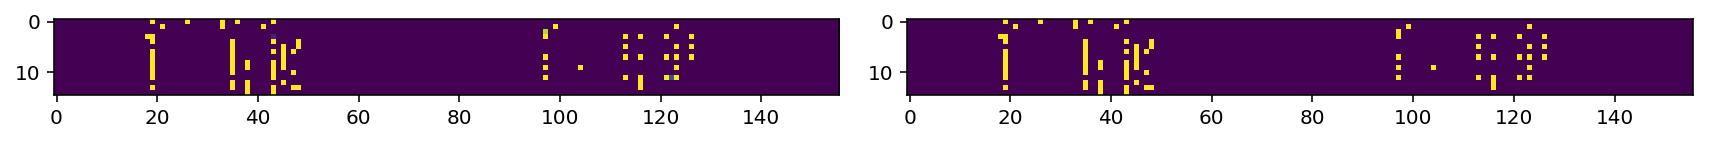

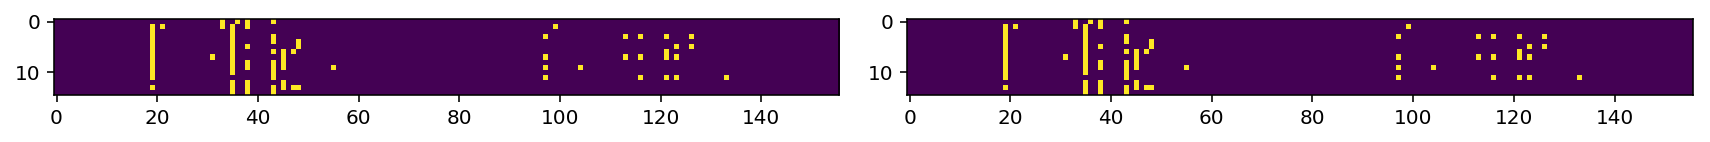

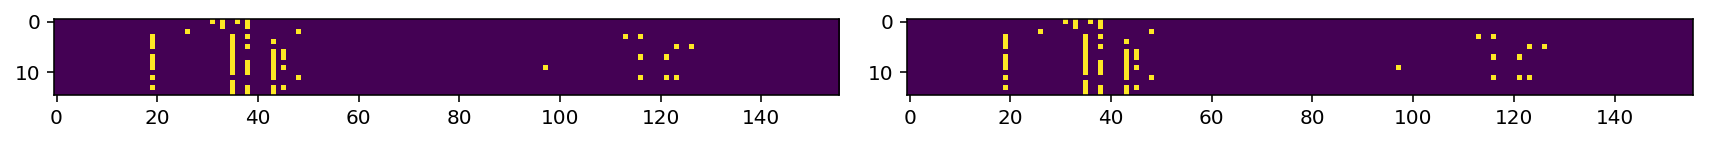

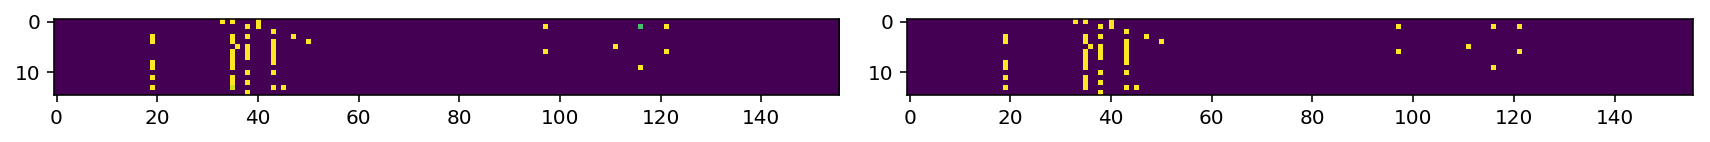

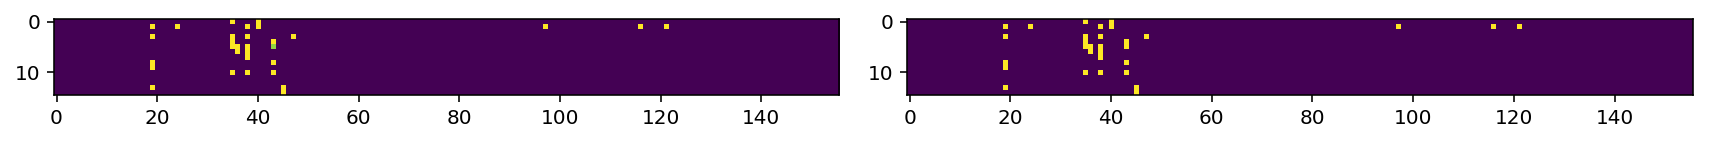

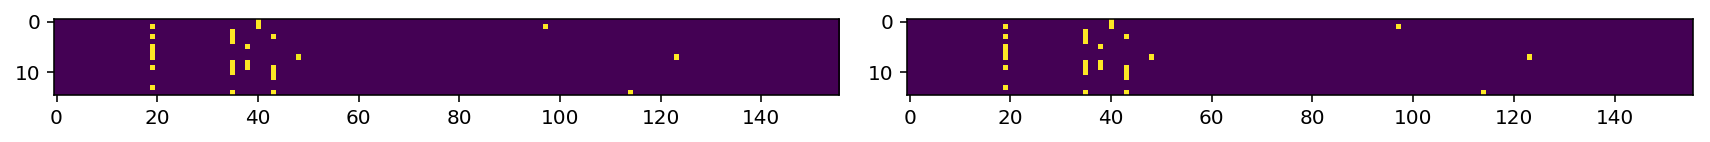

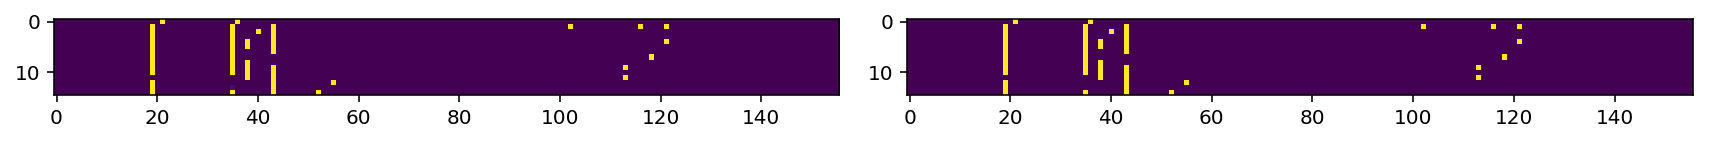

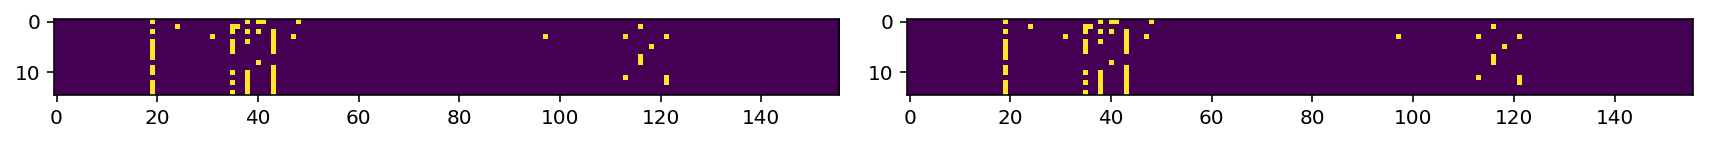

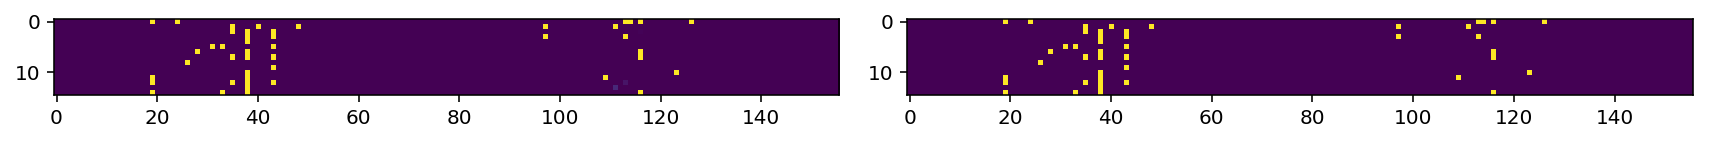

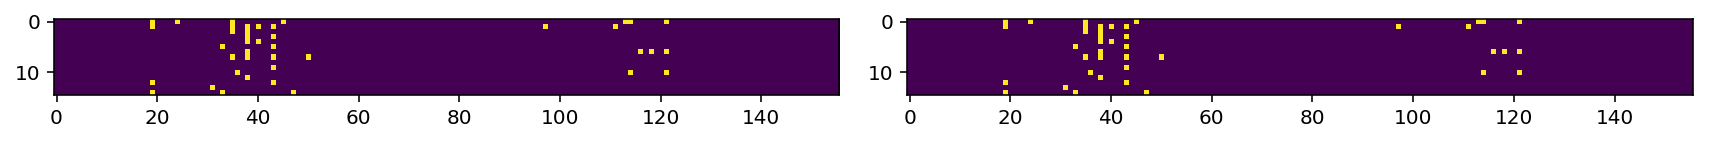

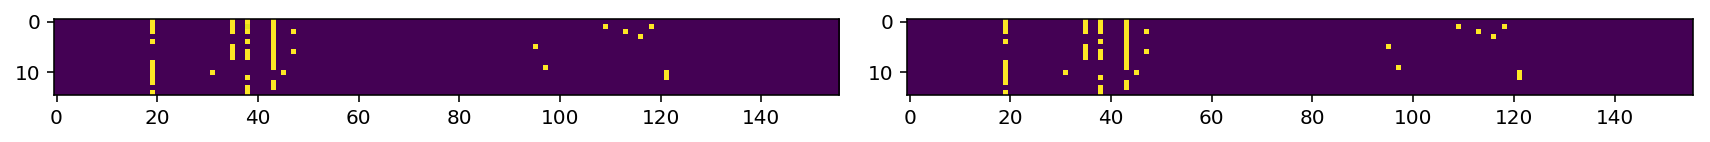

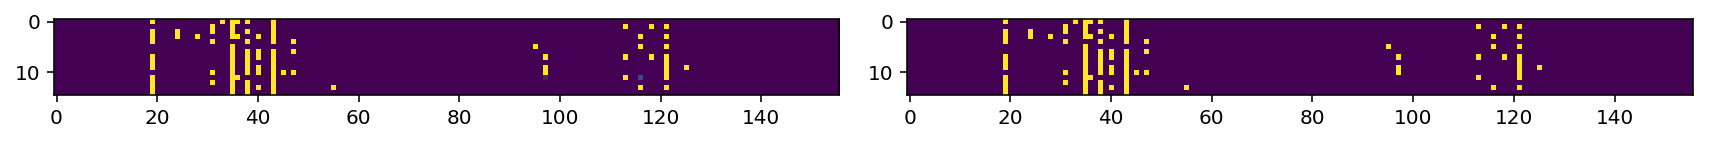

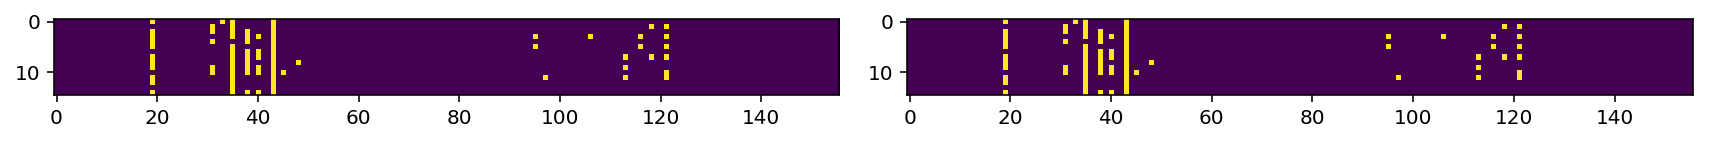

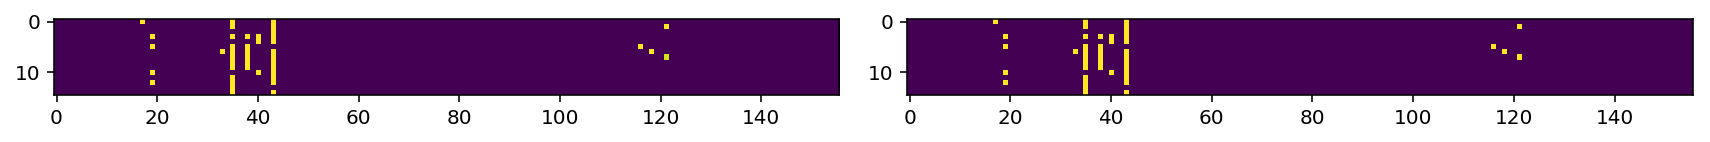

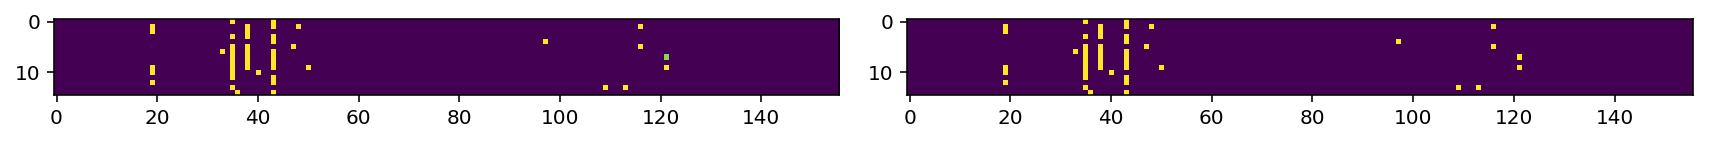

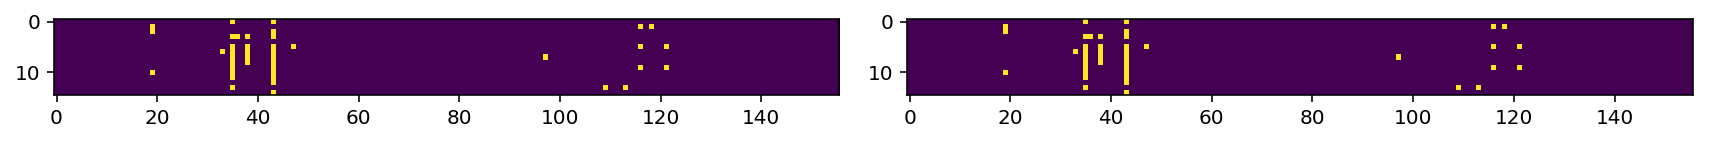

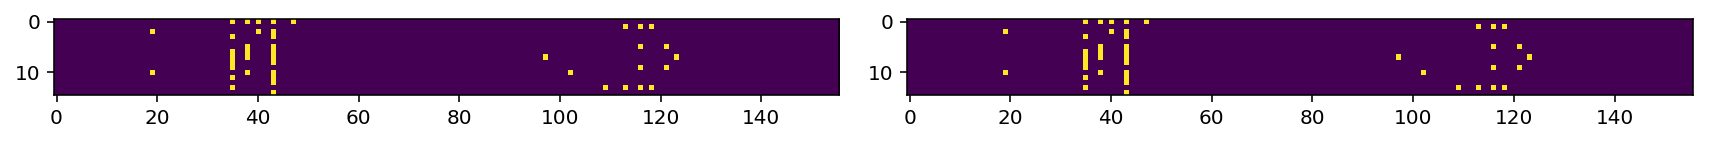

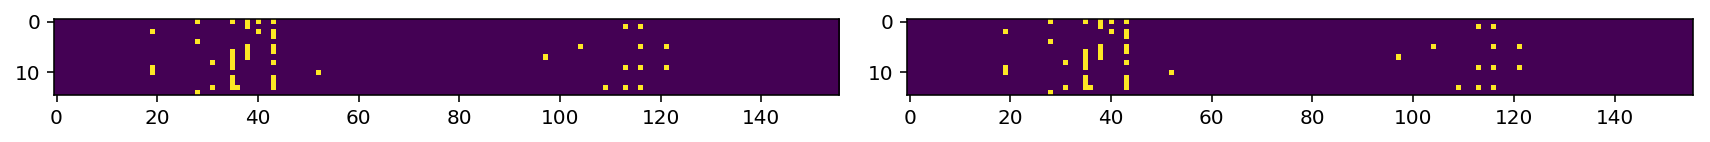

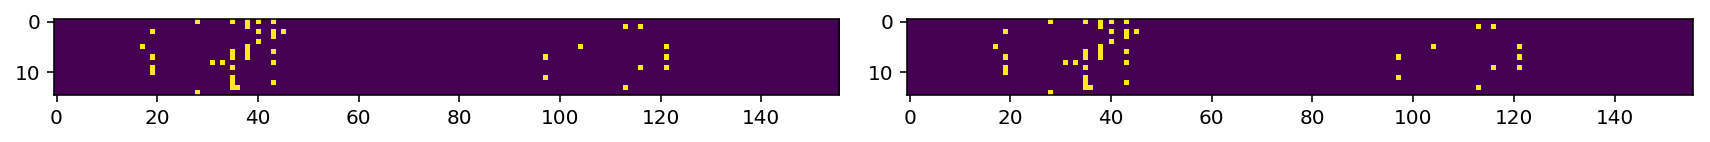

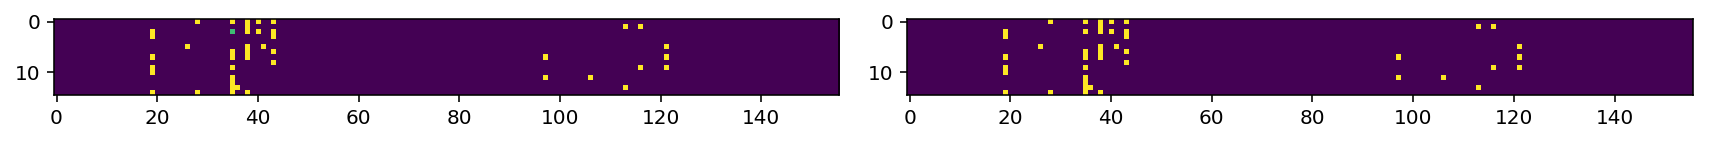

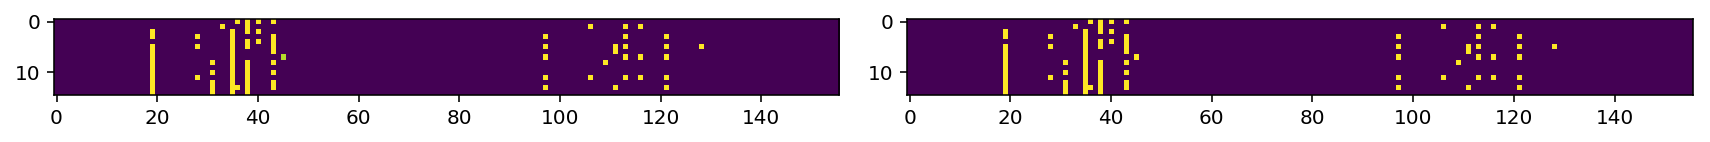

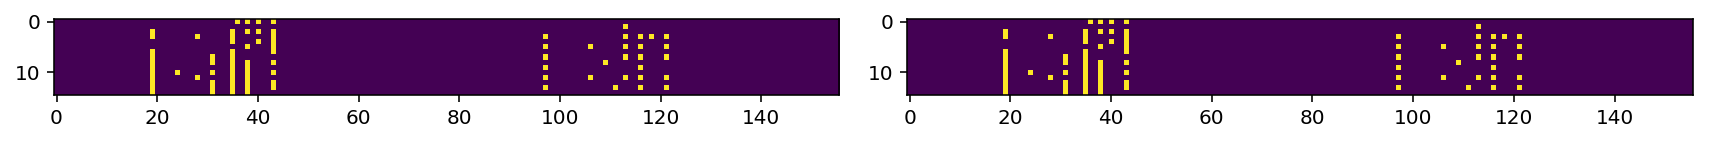

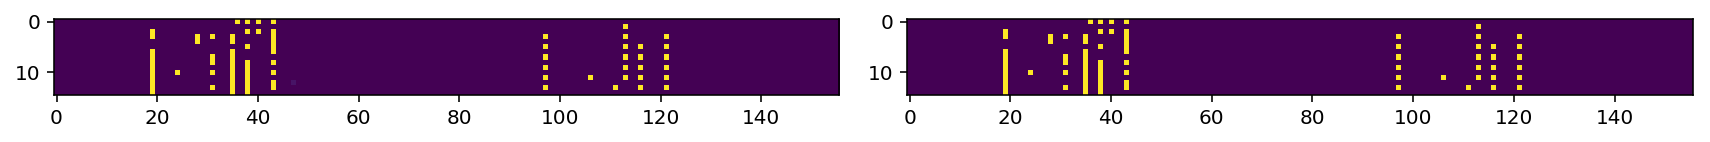

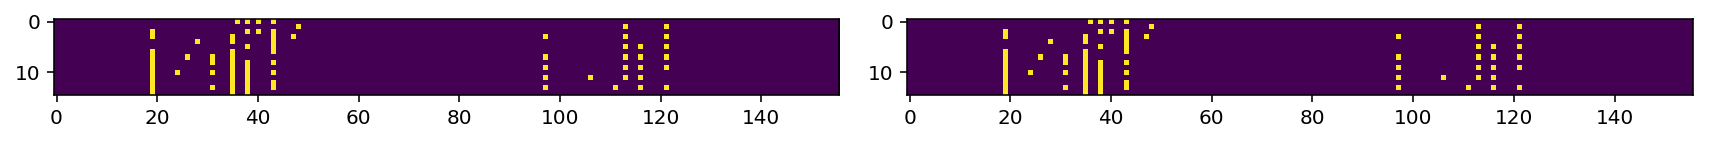

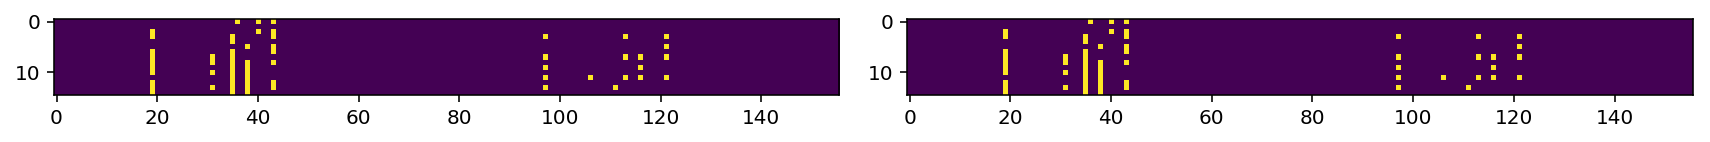

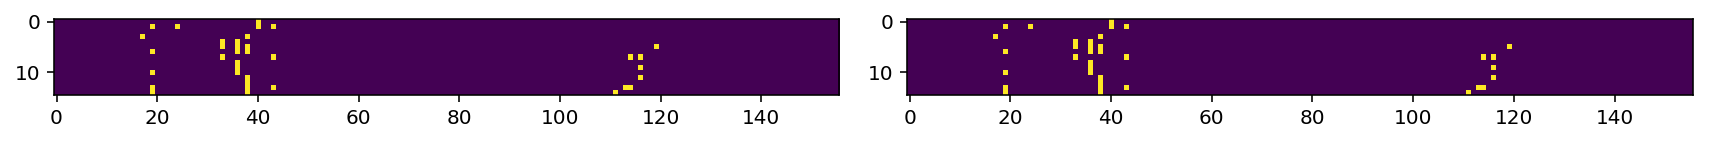

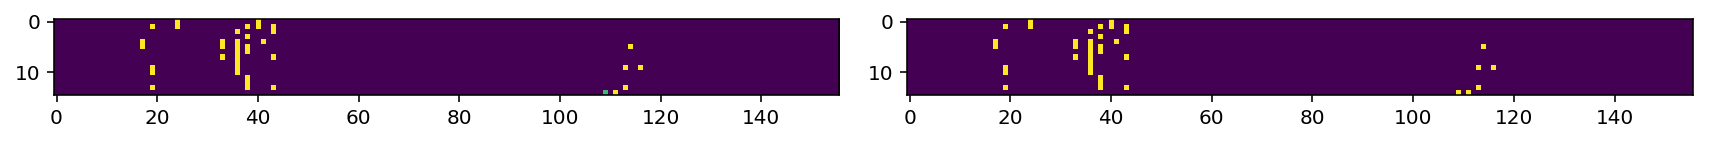

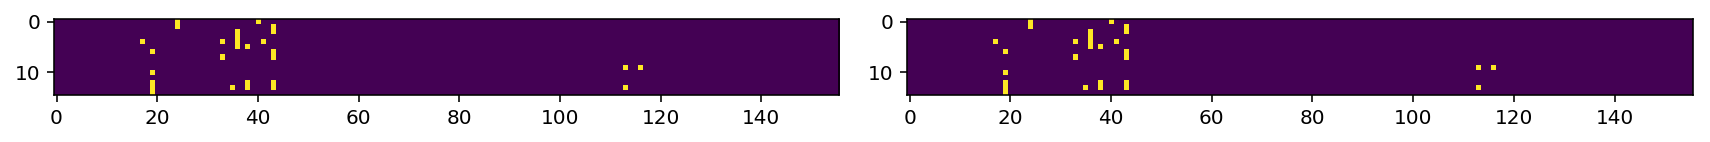

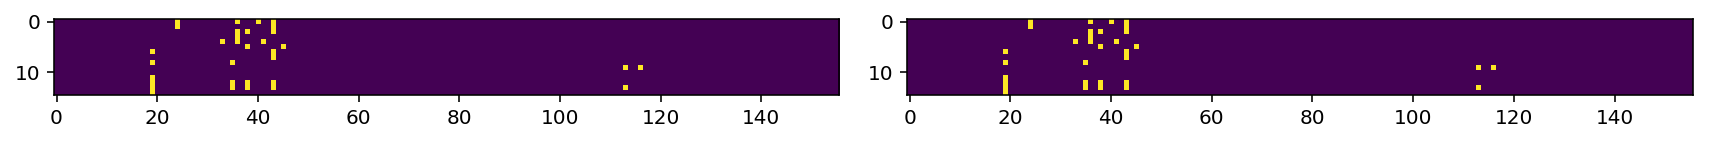

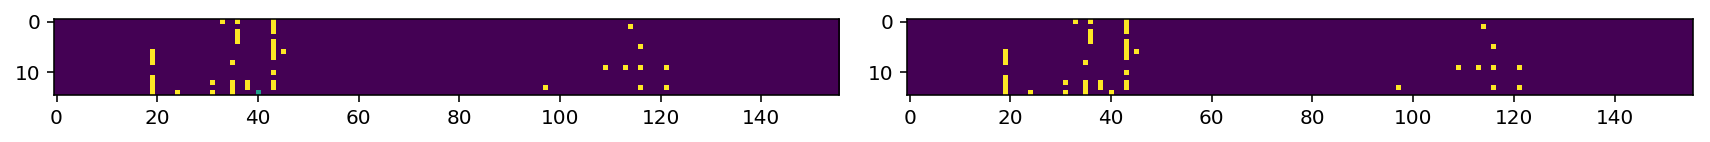

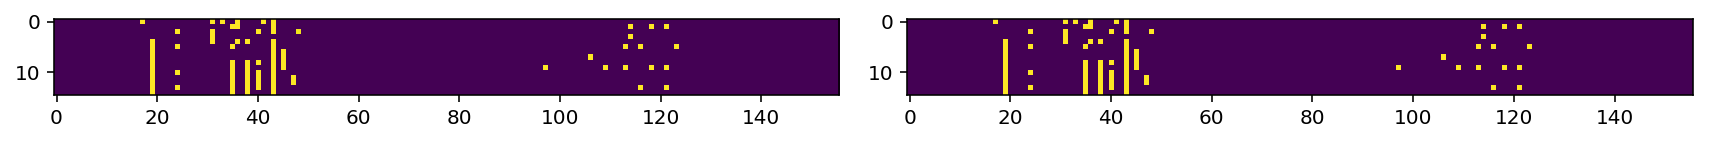

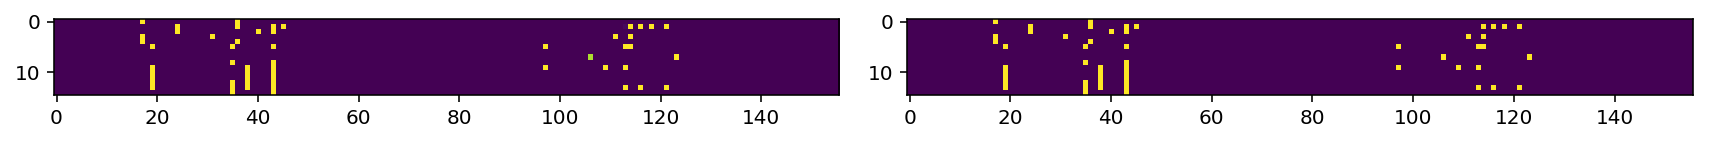

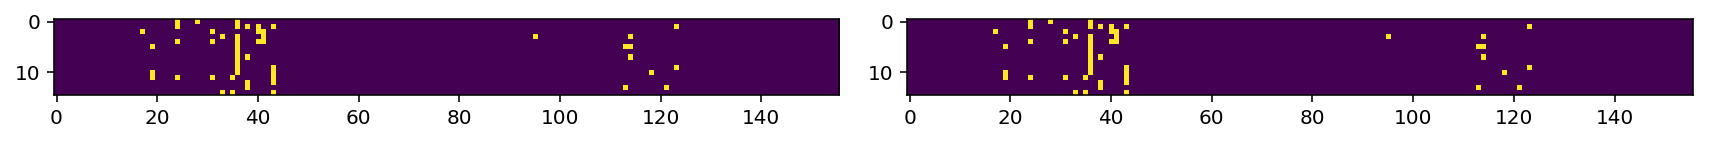

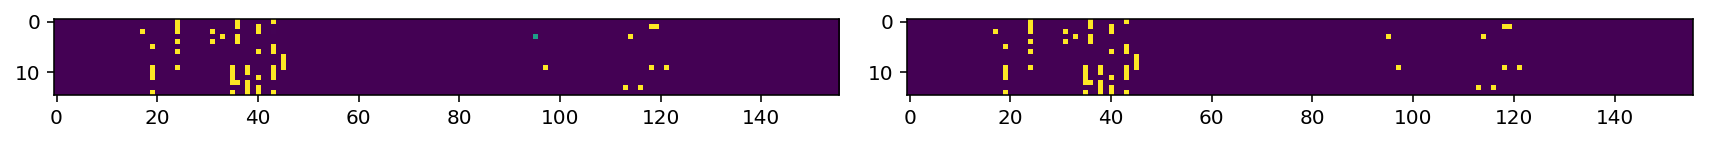

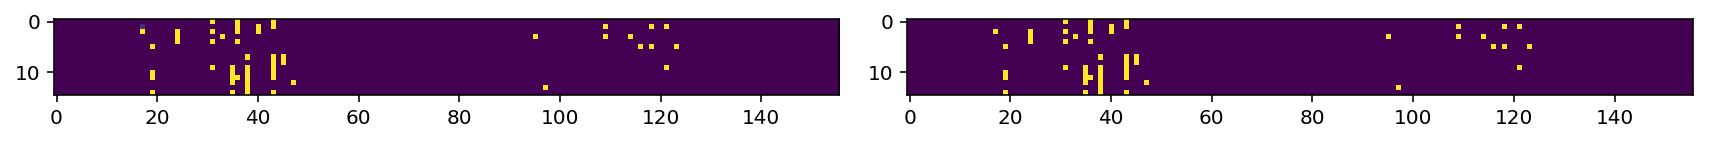

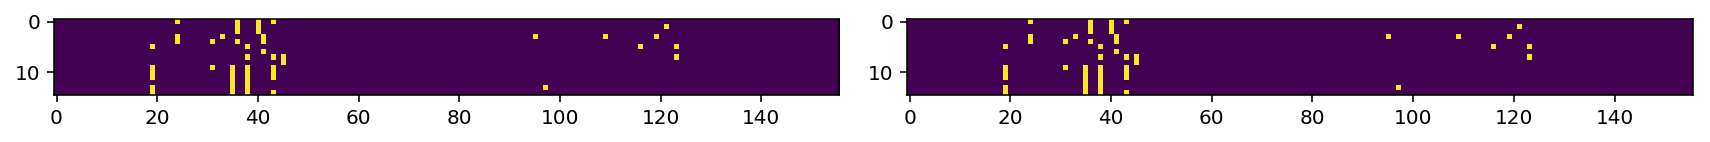

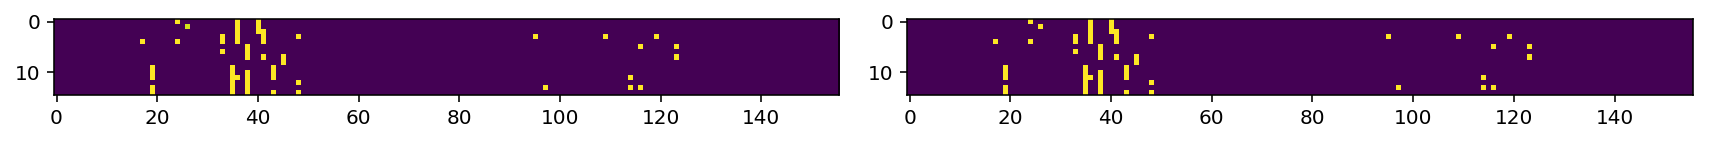

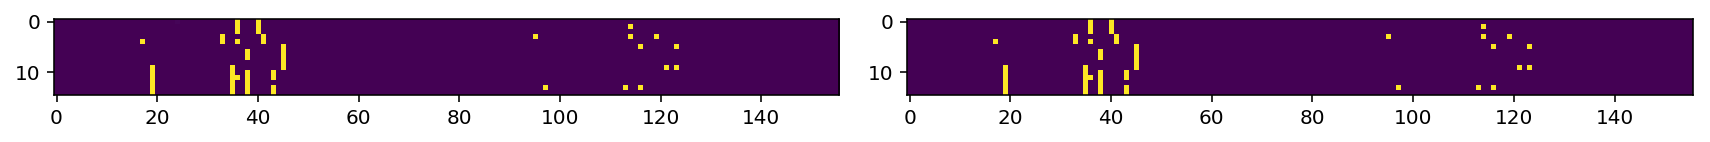

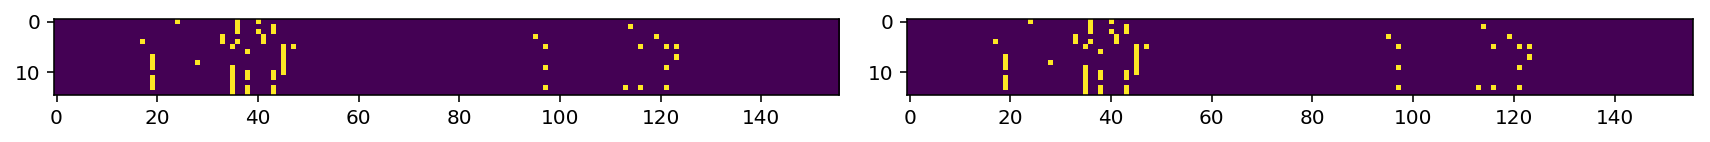

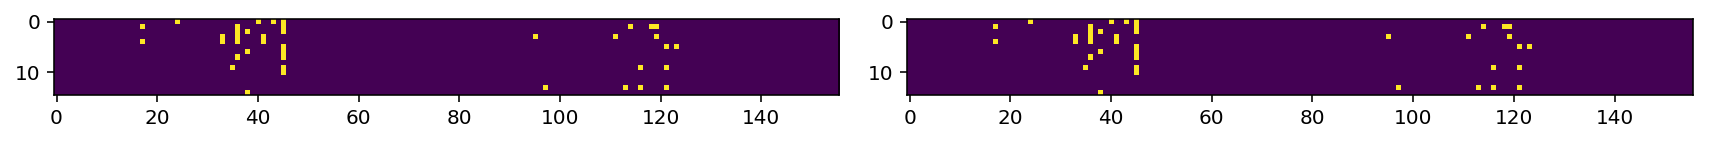

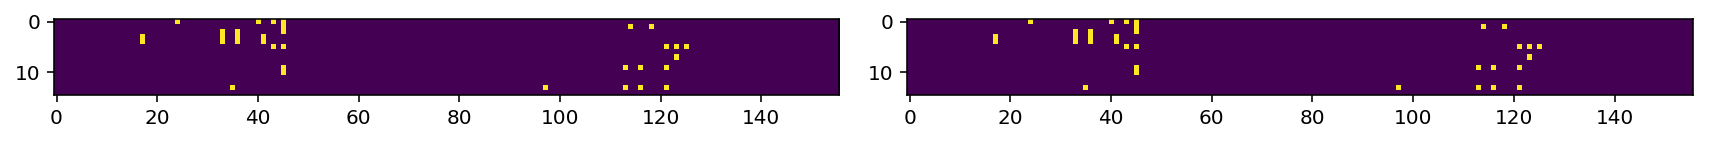

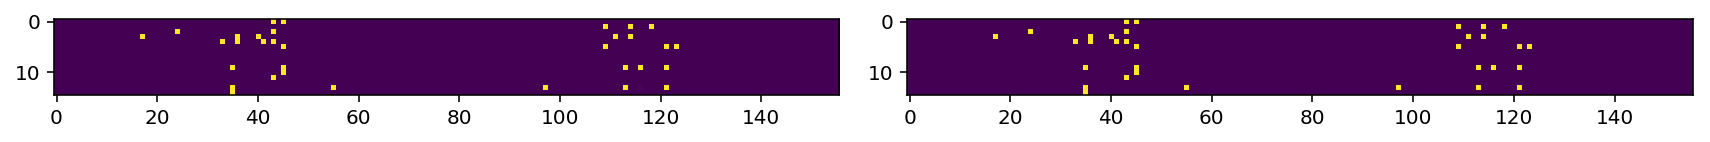

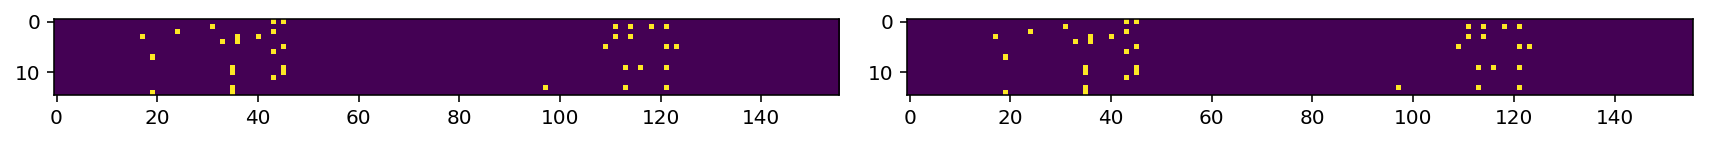

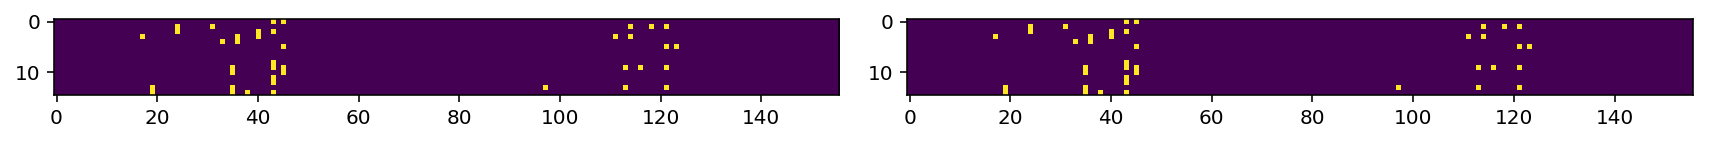

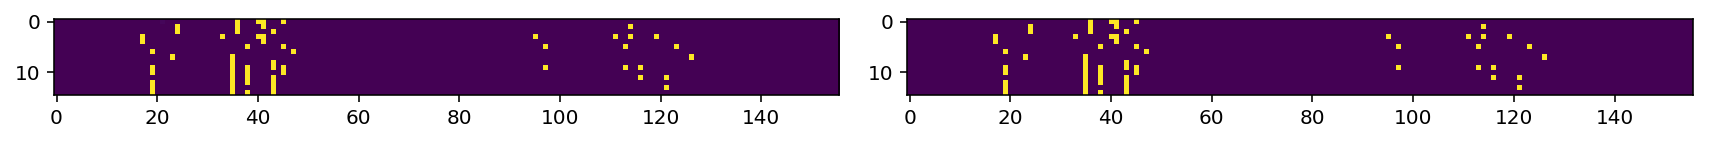

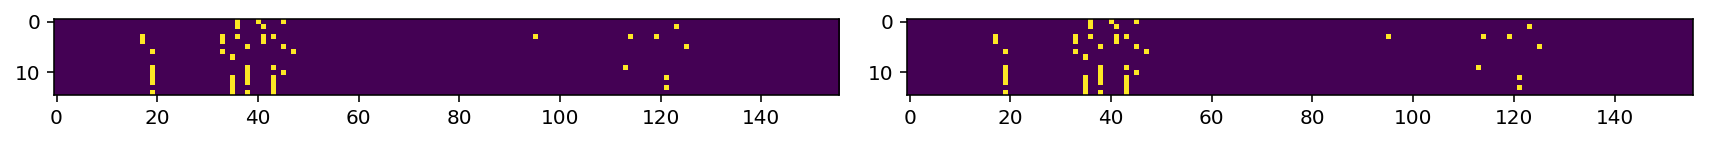

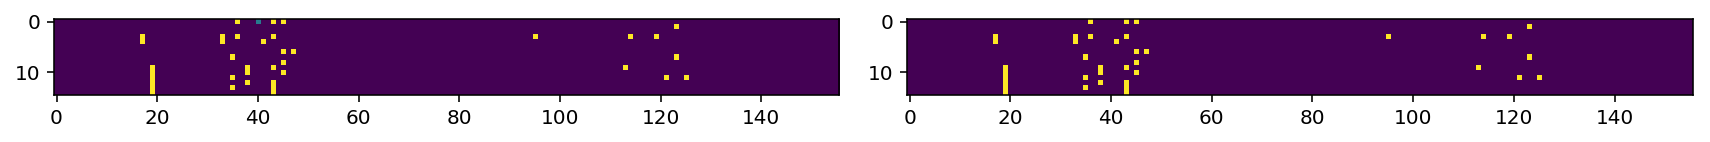

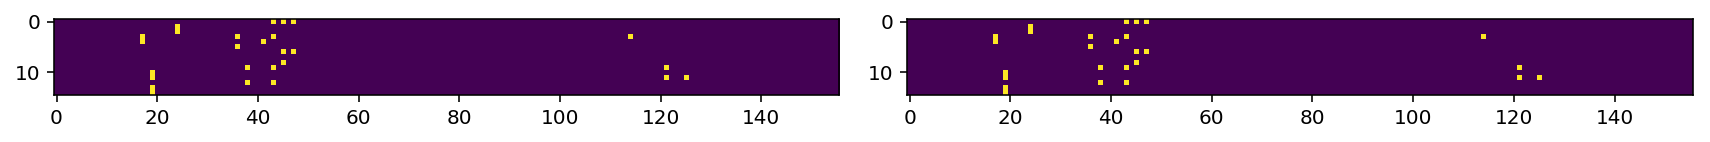

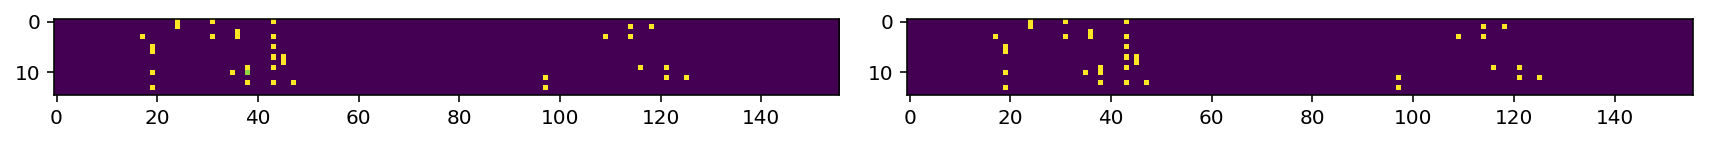

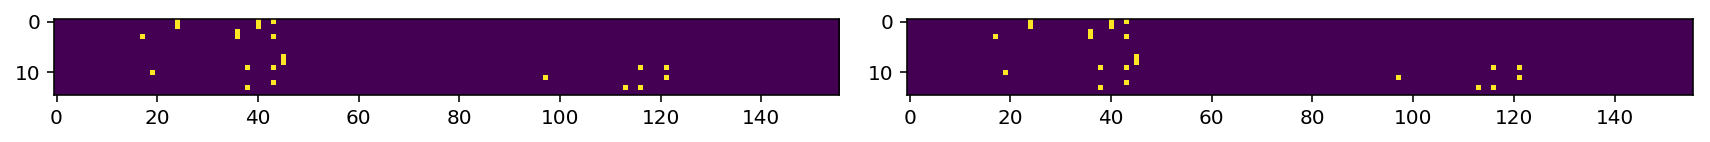

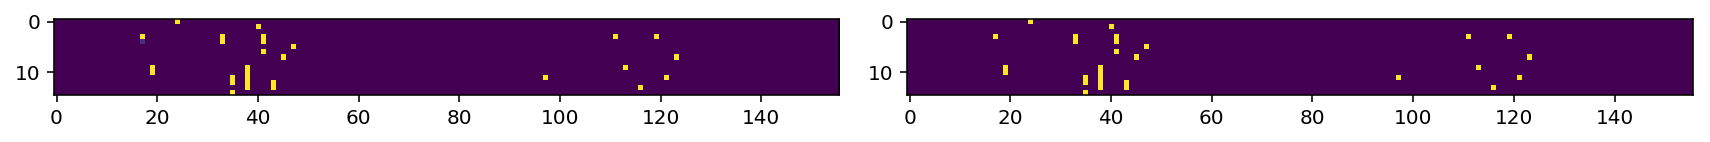

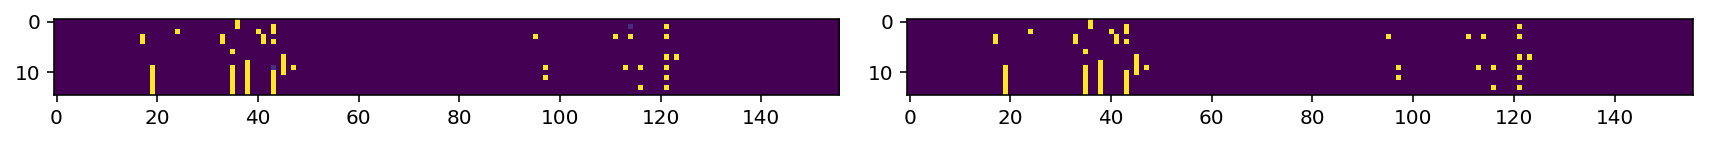

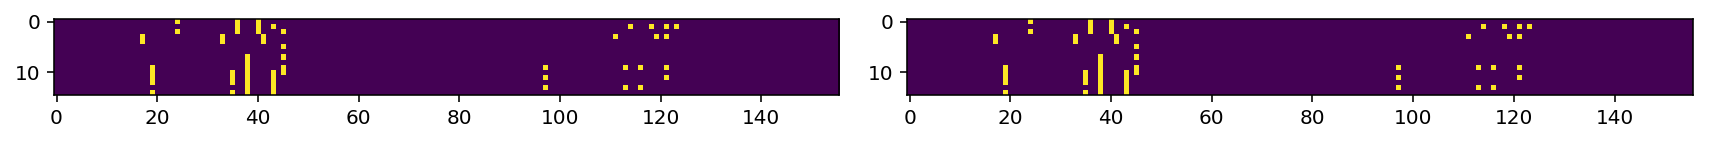

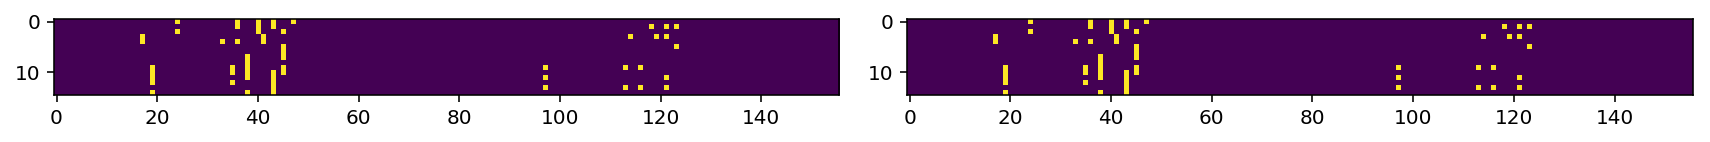

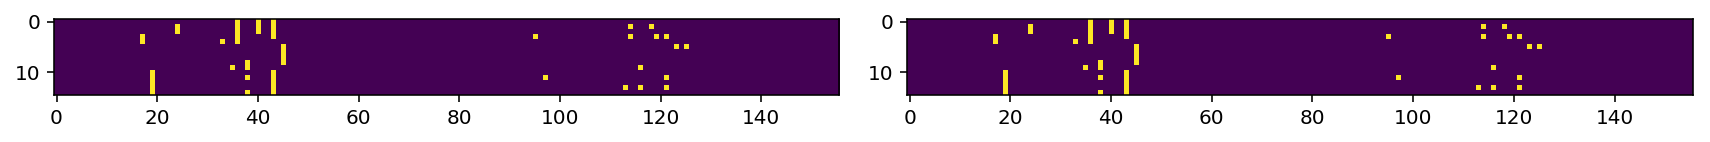

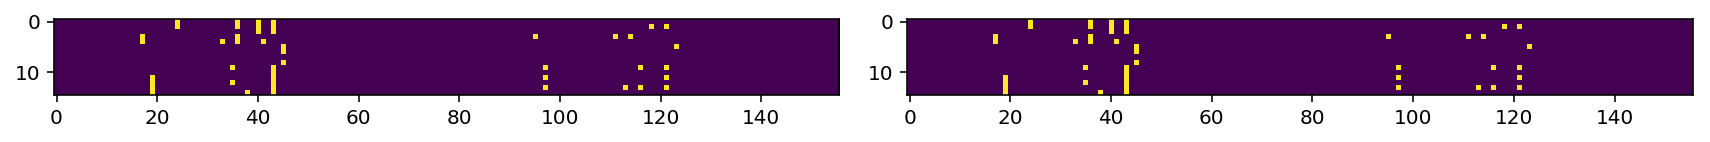

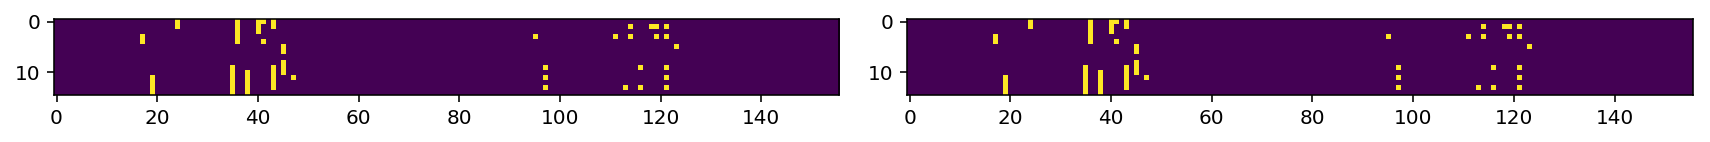

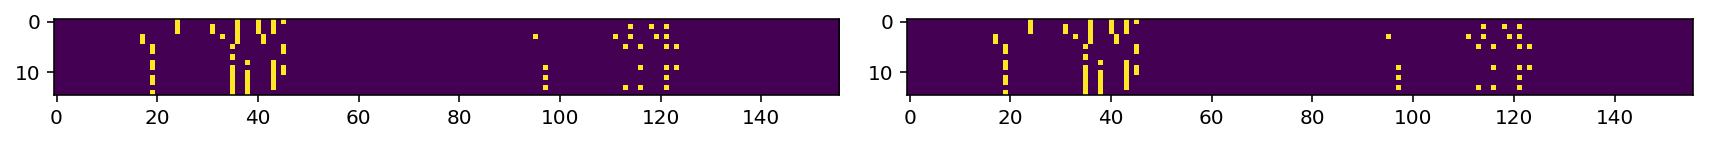

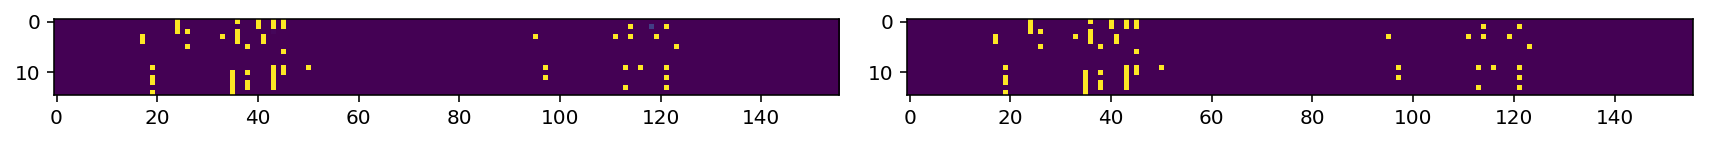

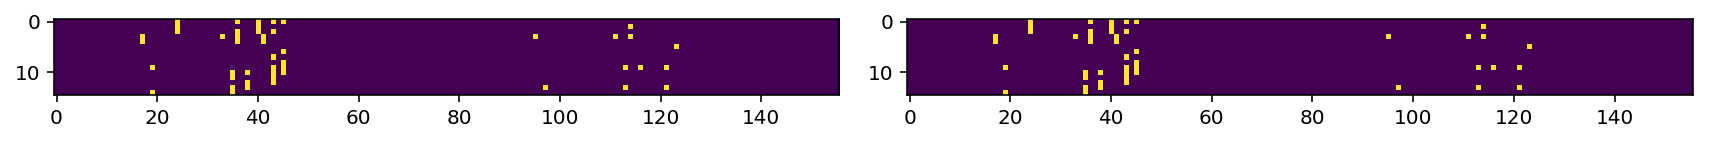

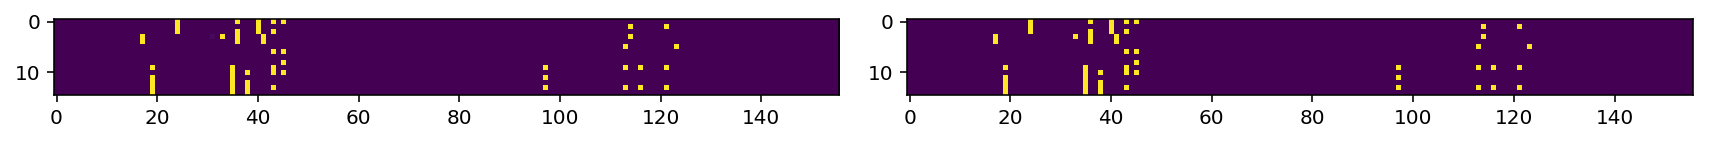

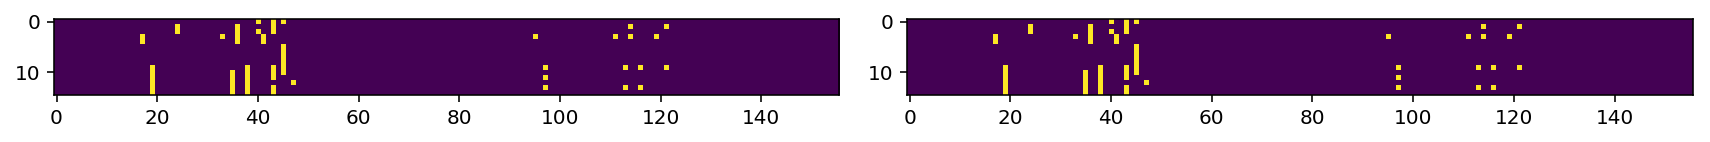

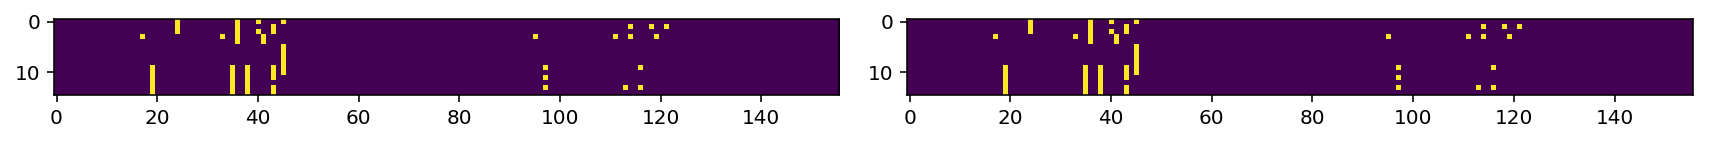

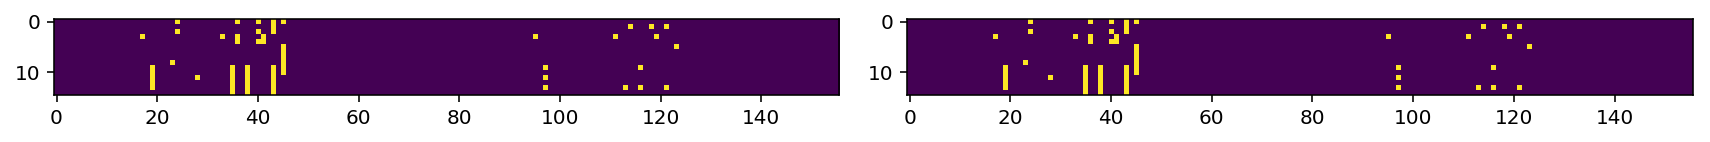

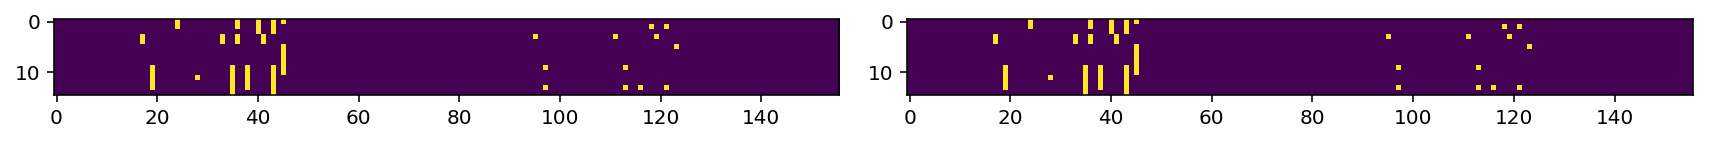

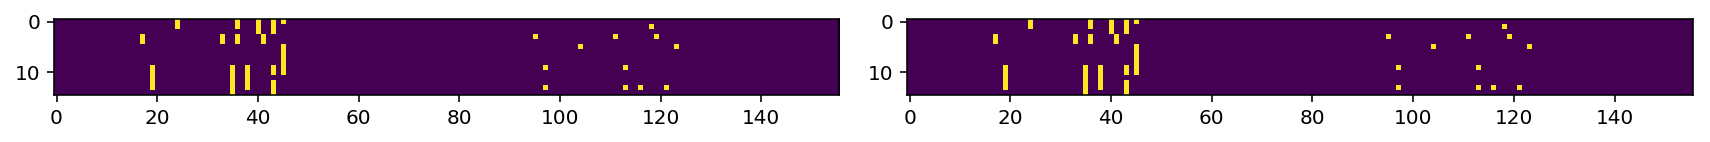

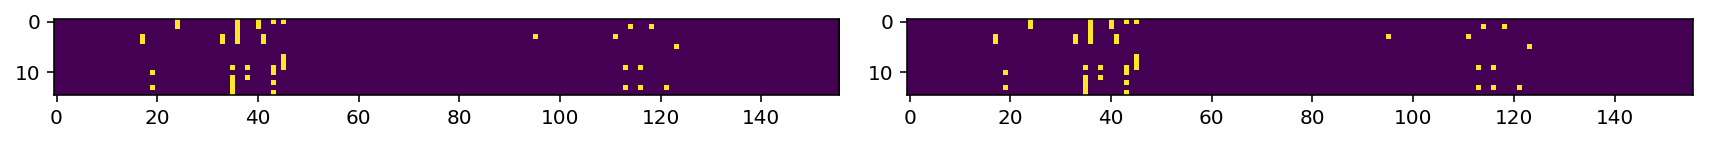

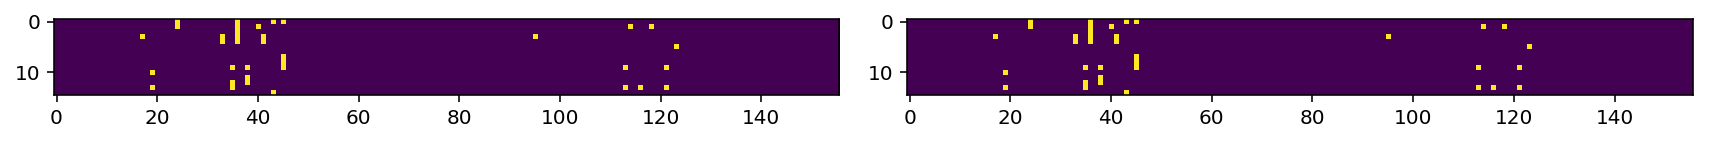

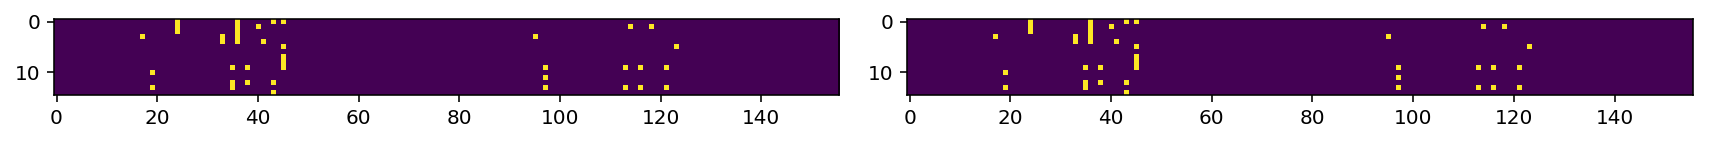

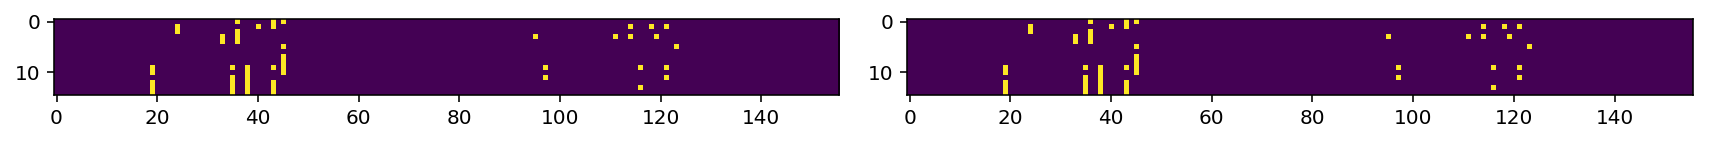

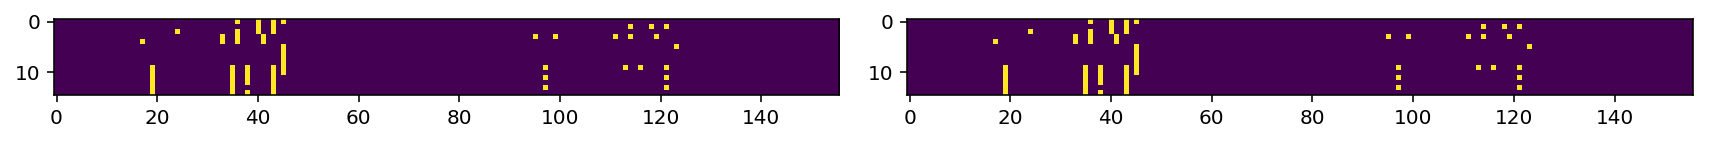

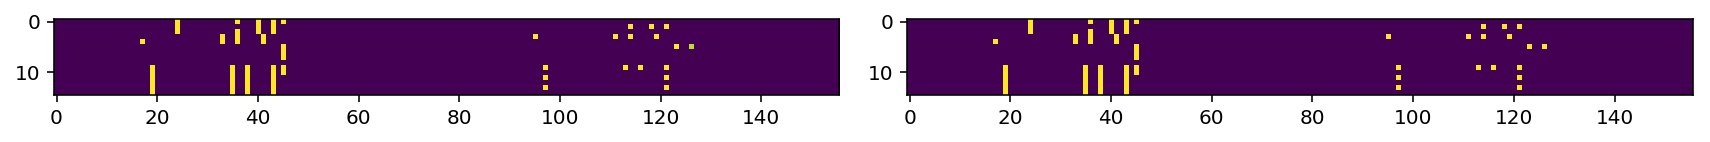

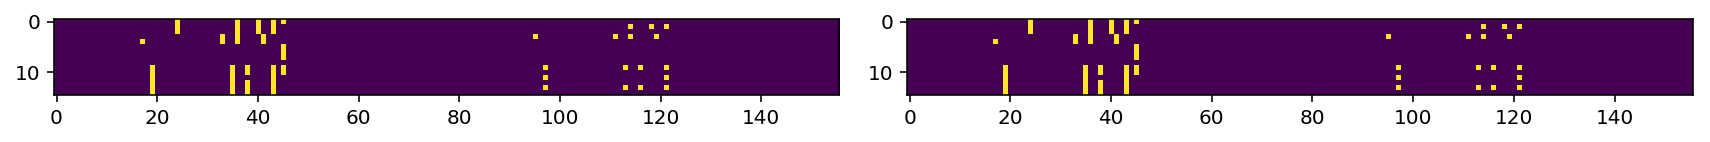

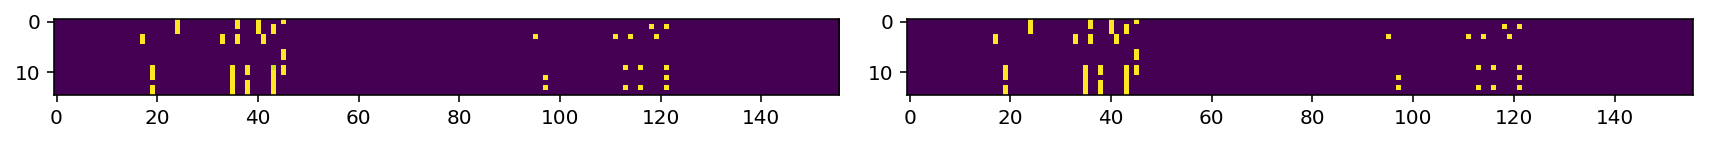

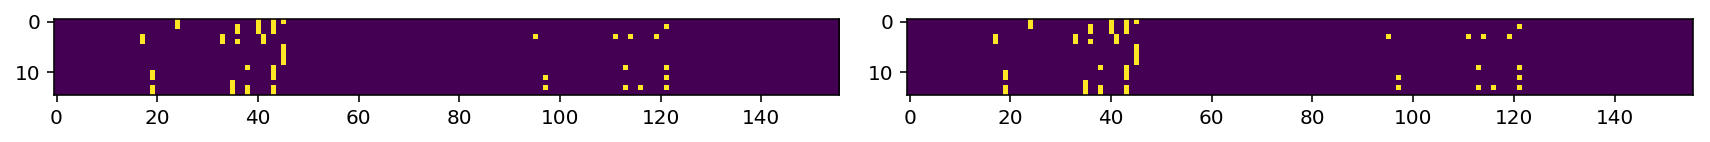

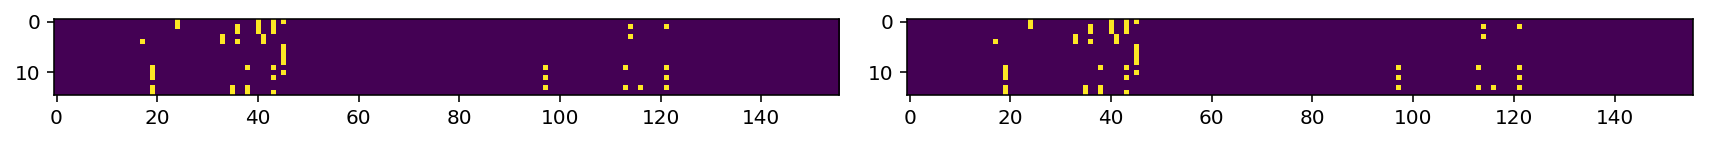

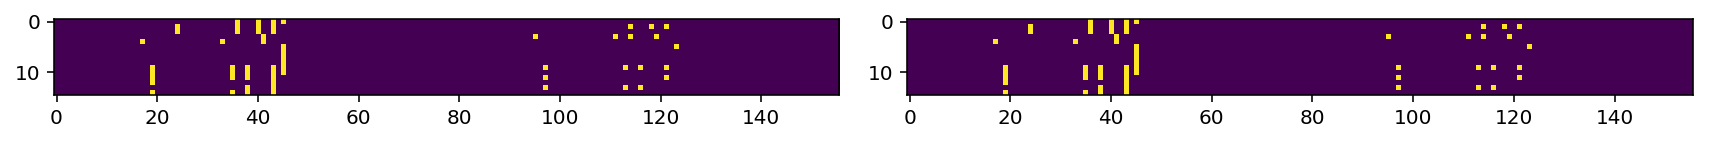

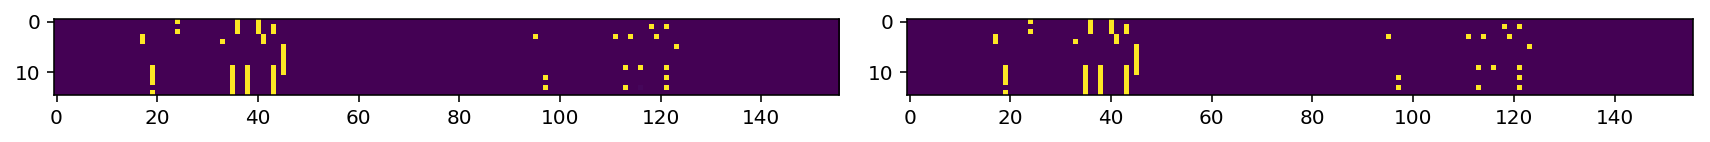

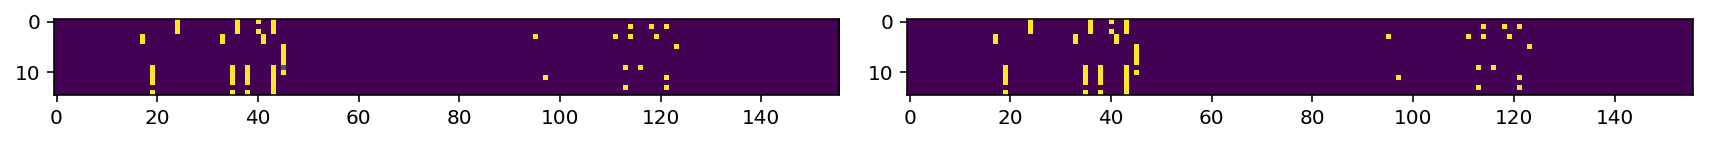

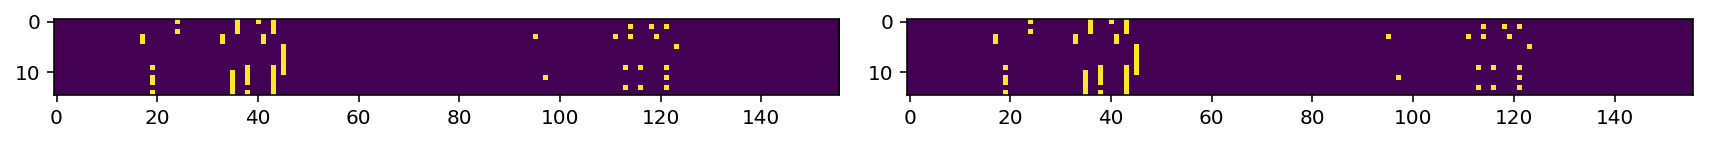

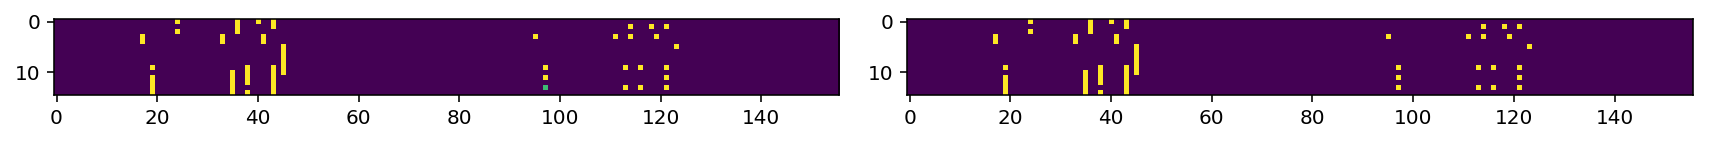

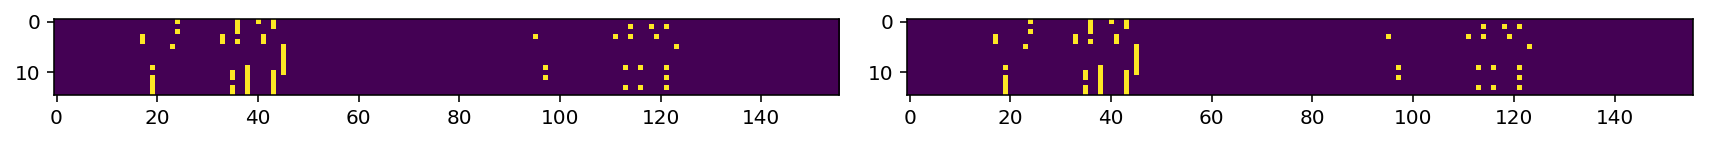

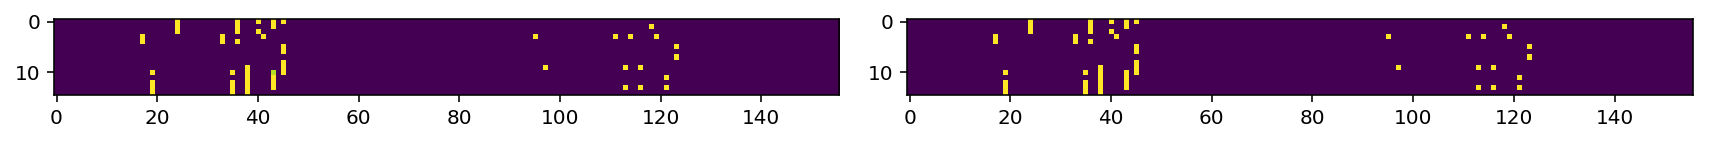

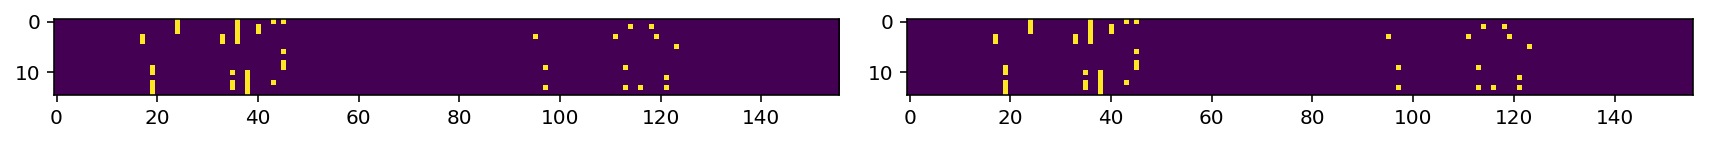

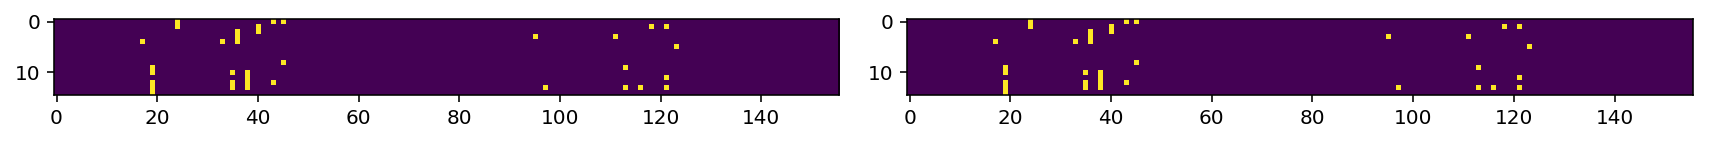

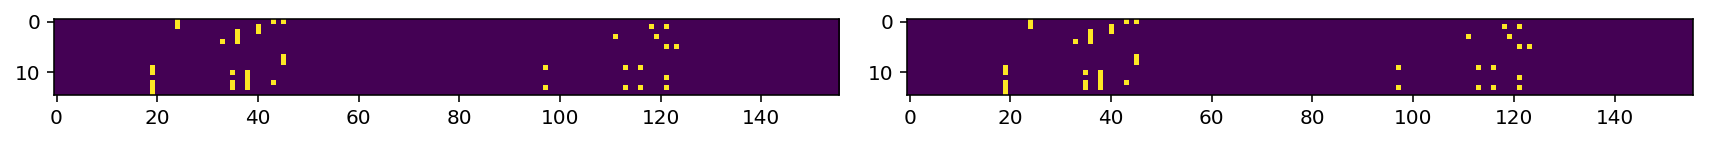

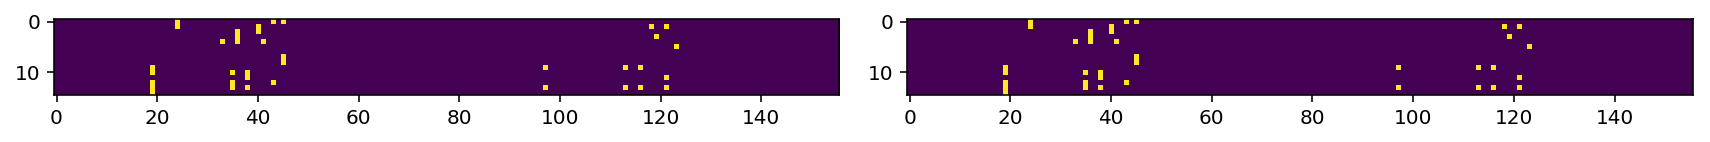

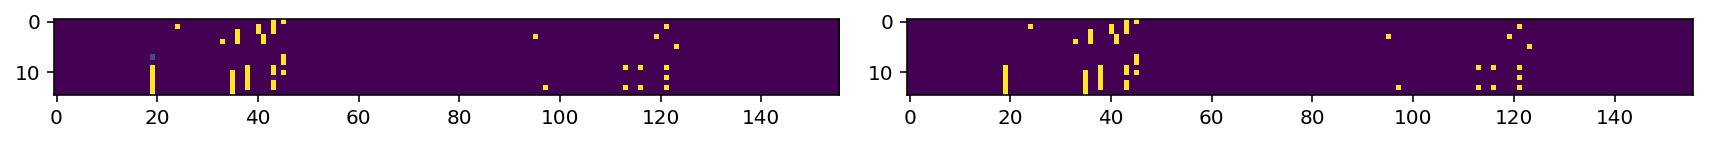

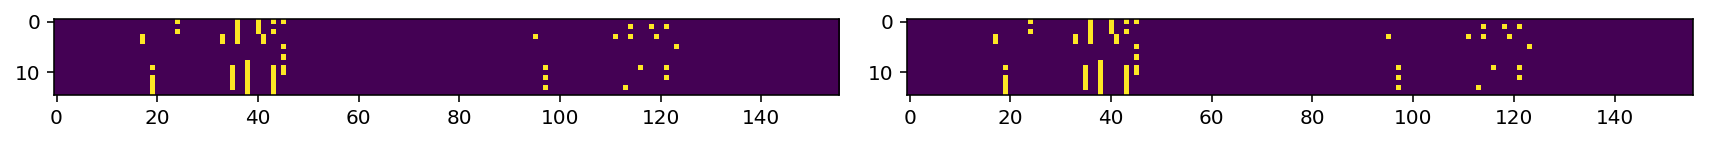

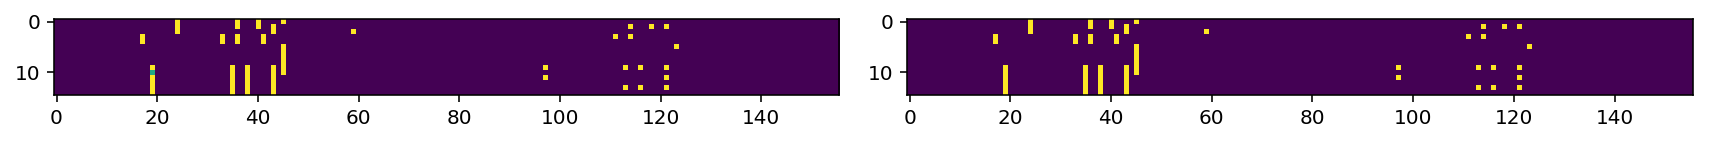

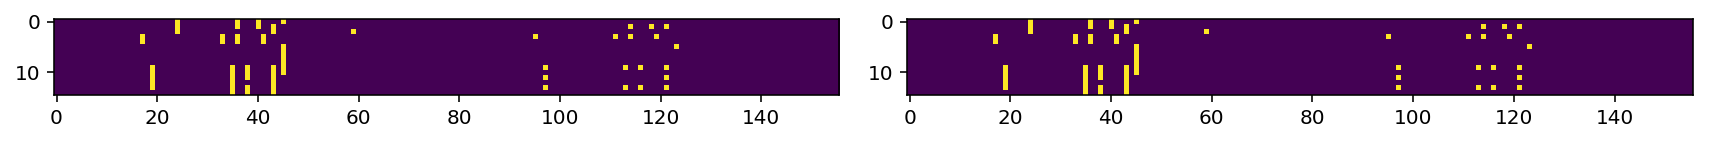

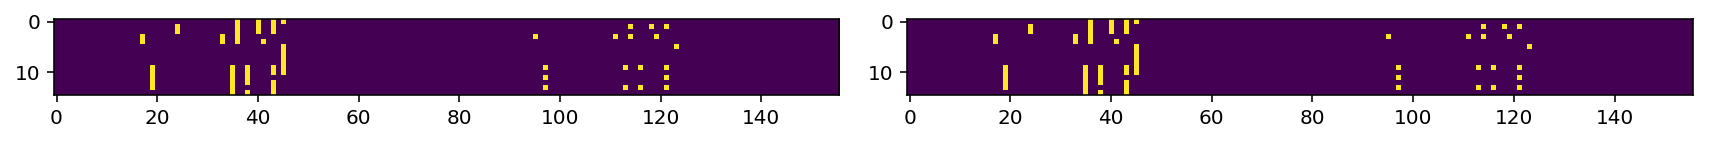

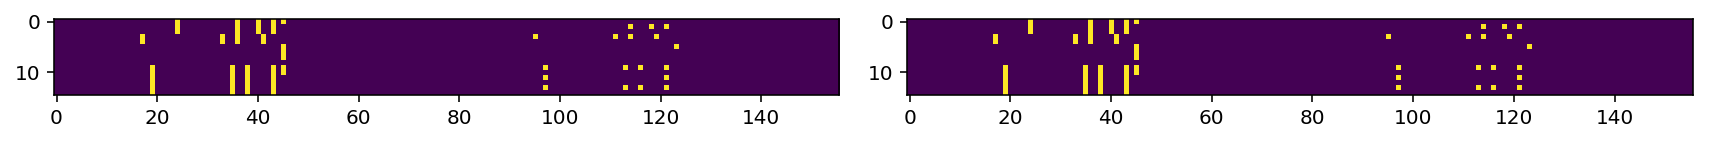

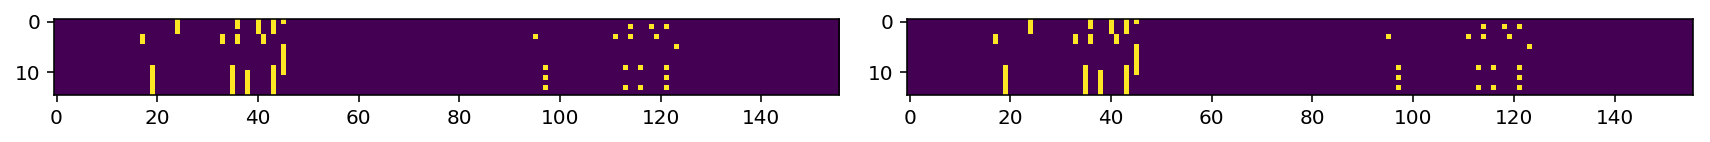

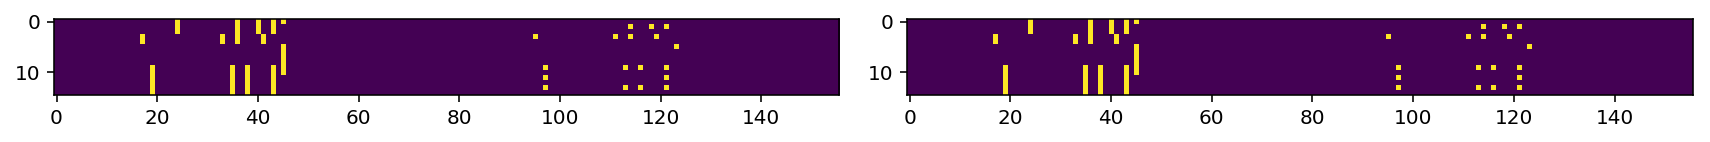

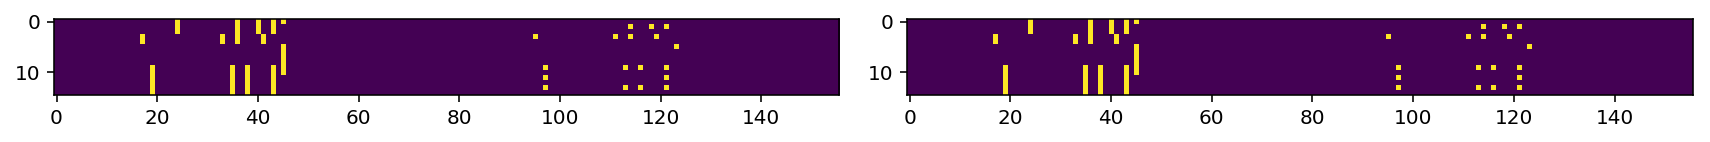

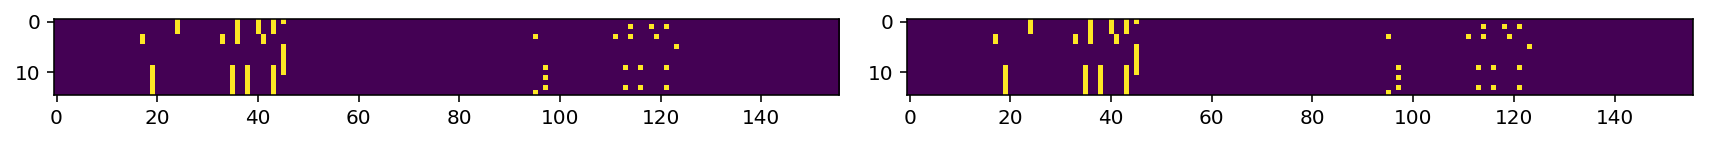

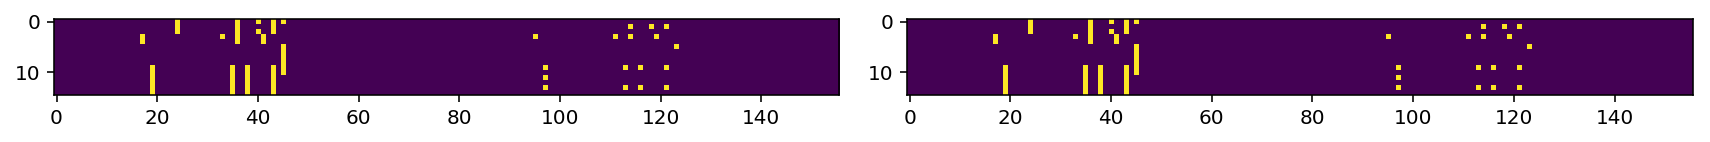

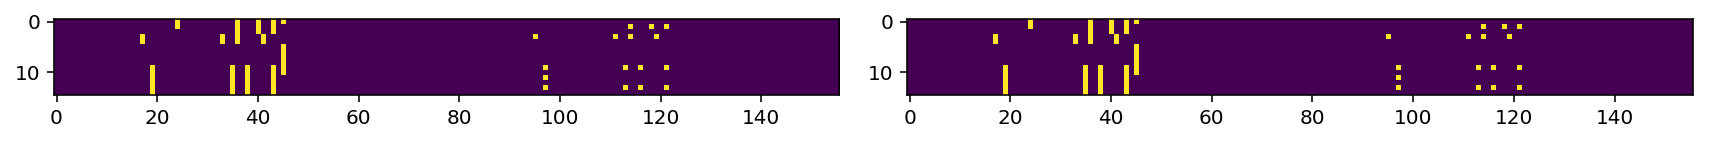

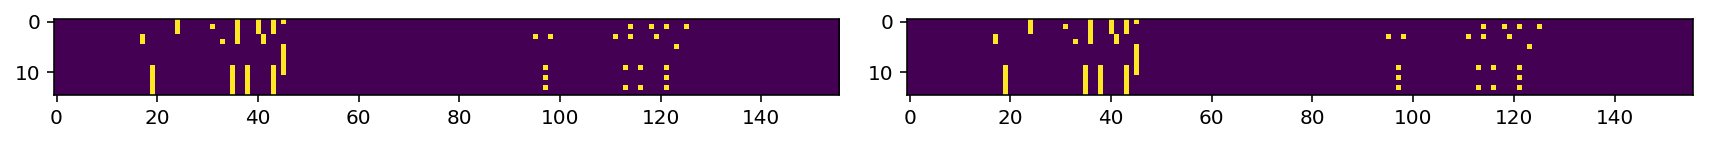

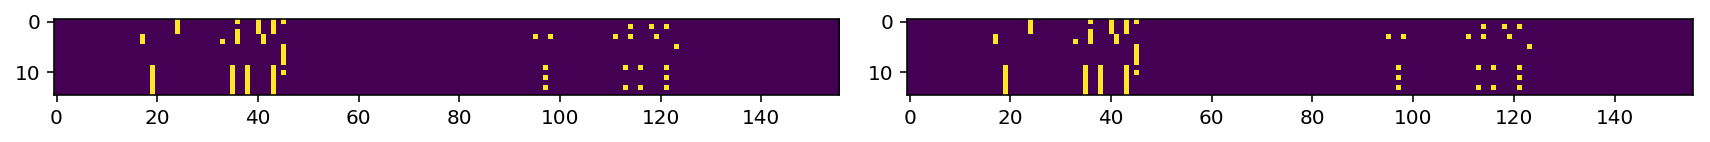

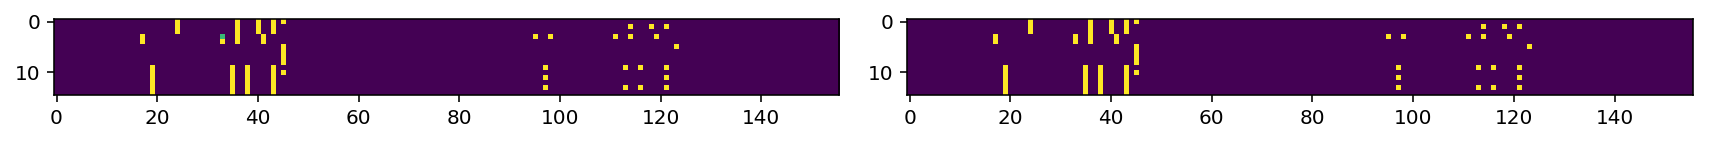

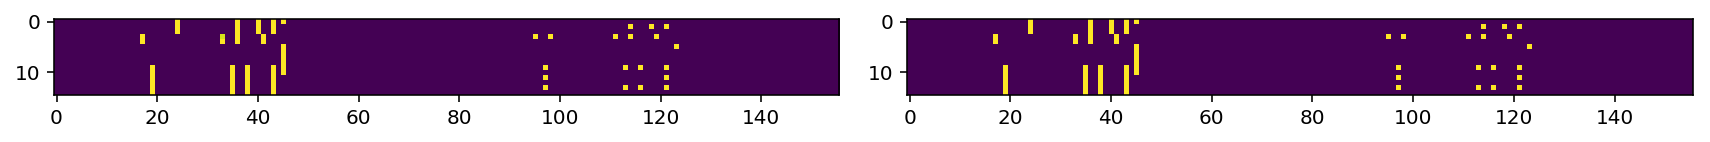

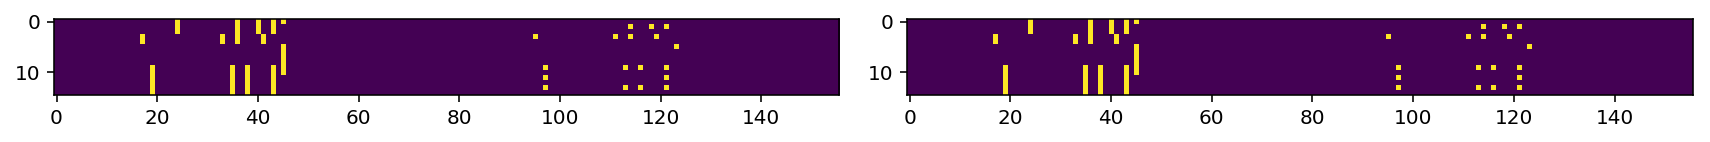

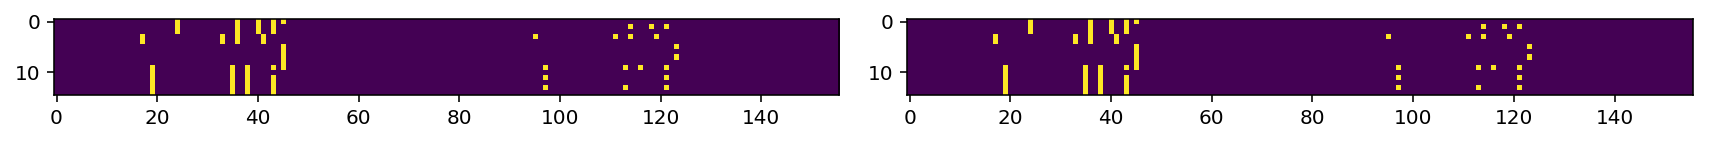

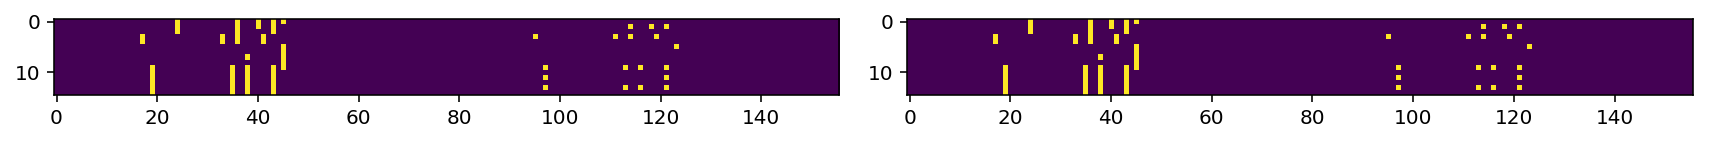

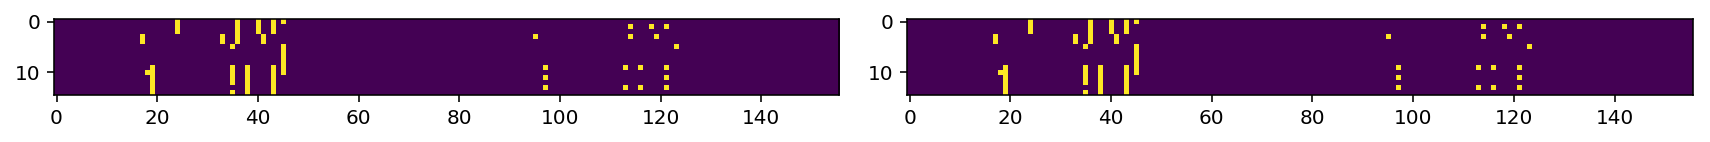

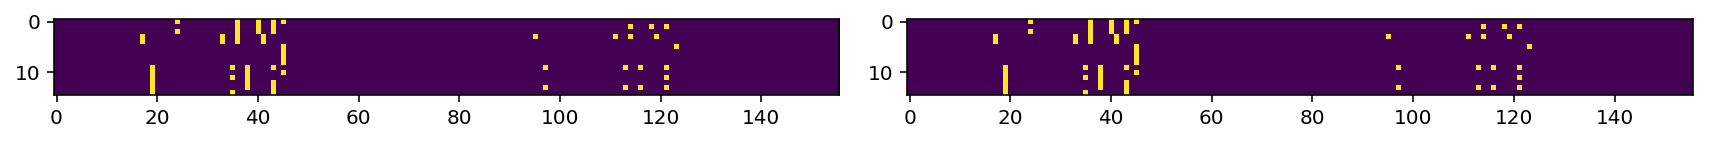

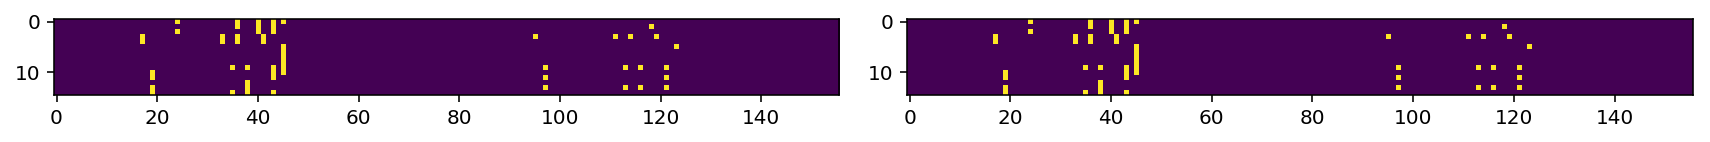

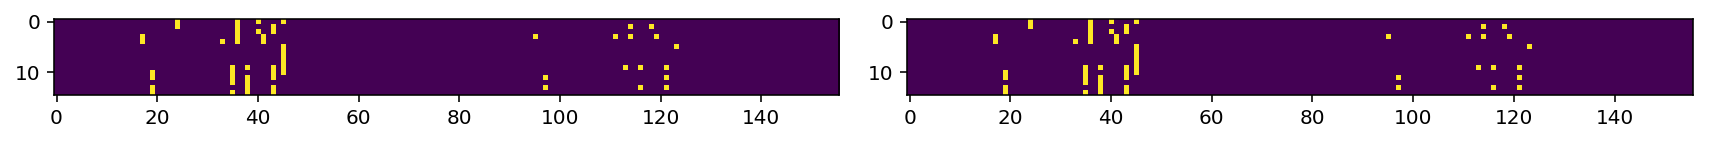

In [ ]:
i = 0
num_epochs = 1000000
batch_size = 100

while i <= num_epochs:
    for song in songs:
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
        song = np.array(song)
        song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
        song = np.reshape(song, [int(song.shape[0]/num_timesteps), song.shape[1]*num_timesteps])
        # Train the RBM on batch_size examples at a time
        for ind in range(1, len(song), batch_size): 
            X_mb = song[ind:ind+batch_size]
#            _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})
    
            if i % 1000 == 0:
               # print('Iter: {}'.format(i))
               # print('Loss: {:.4}'. format(loss))

#             samples = sess.run(X_samples, feed_dict={z: np.random.randn(1,z_dim)})
                samples = sess.run(G_sample, feed_dict={Z: sample_Z(1, Z_dim)})
                
                S = np.reshape(samples, (num_timesteps, 2*note_range))
                thresh_S = S>=0.5
                plt.figure(figsize=(12,2))
                plt.subplot(1,2,1)
                plt.imshow(S)
                plt.subplot(1,2,2)
                plt.imshow(thresh_S)
                plt.tight_layout()
                plt.pause(0.1)
                midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/generated_chord_{}".format(i))
#                 print(i)
            i += 1